# Debug effect size

In [ ]:

import os
import sys
import numpy as np
import pandas as pd
from collections import Counter

os.environ["NOVA_HOME"] = "/home/projects/hornsteinlab/Collaboration/NOVA/"
sys.path.insert(1, os.getenv("NOVA_HOME"))
print(os.getenv("NOVA_HOME"))

from src.common.utils import get_if_exists


patient_to_plate = {'EDi022':1,'EDi029':2,'EDi037':3}

def _prepare_embeddings_df(embeddings: np.ndarray[float], 
                           labels: np.ndarray[str], paths) -> pd.DataFrame:
        """
        Create a DataFrame with embeddings and metadata parsed from sample labels.
        Parses labels of the form "marker_cellline_condition_batch_rep" into separate columns.

        Args:
            embeddings (np.ndarray[float]):     Embeddings array of shape (n_samples, n_features).
            labels (np.ndarray[str]):           Array of label strings matching embedding rows.

        Returns:
            pd.DataFrame: DataFrame containing embedding columns plus columns:
                ['marker', 'cell_line', 'condition', 'batch', 'rep'].

        Raises:
            ValueError: If any label string does not contain exactly 5 underscore-separated parts.
        """
        df = pd.DataFrame(embeddings)
        df['label'] = labels
        df['site'] = [p.split(os.sep)[-2] for p in paths]
        df['tile_number'] = [int(p.split(os.sep)[-1]) for p in paths]

        # Split and validate
        split_labels = df['label'].str.split('_', expand=True)

        # Check that all labels have 5 parts
        if split_labels.shape[1] != 5:
            invalid_labels = df['label'][split_labels.isnull().any(axis=1)].tolist()
            raise ValueError(
                f"Some label strings are invalid (expected 5 parts separated by '_').\n"
                f"Example invalid labels: {invalid_labels[:5]}"
            )
        df[['marker', 'cell_line', 'condition', 'batch', 'rep']] = split_labels
        return df

def _calculate_all_effects(embeddings_df: pd.DataFrame, 
                               embeddings_dim:int, n_boot:int=1000, data_config=None, subsample_fraction:float=1) -> pd.DataFrame:
        """
        Calculate batch-level effect sizes for all marker-baseline-perturbation combinations.

        Args:
            embeddings_df (pd.DataFrame):
                DataFrame with embedding vectors and metadata, created by `_prepare_embeddings_df`.
            embeddings_dim (int):
                Dimensionality of the embedding vectors.
            n_boot (int)
                Number of bootstrap iterations (default: 1000).

        Returns:
            pd.DataFrame
                DataFrame with per-batch effect size statistics including:
                ['marker', 'baseline', 'pert', 'batch', 'baseline_size', 'perturb_size', 
                'effect_size', 'variance'].
        """

        results = []
        baseline = get_if_exists(data_config, 'BASELINE', None)
        assert baseline is not None, "BASELINE is None. You have to specify the baseline (for example: WT_Untreated or TDP43_Untreated)"

        print(f"[AnalyzerEffects] baseline: {baseline}")
        baseline_cell_line, baseline_cond = baseline.split('_')
        baseline_df = embeddings_df[
                            (embeddings_df.cell_line == baseline_cell_line) &
                            (embeddings_df.condition == baseline_cond)]

        pert = get_if_exists(data_config, 'PERTURBATION', None)
        assert baseline is not None, "PERTURBATION is None. You have to specify the PERTURBATION (for example: WT_stress or TDP43_DOX)"

        print(f"[AnalyzerEffects] pert: {pert}")
        pert_cell_line, pert_cond = pert.split('_')
        pert_df = embeddings_df[
                        (embeddings_df.cell_line == pert_cell_line) &
                        (embeddings_df.condition == pert_cond)]
        
        # Group each DataFrame by marker and batch separately
        baseline_groups = baseline_df.groupby(['marker', 'batch'])
        pert_groups = pert_df.groupby(['marker', 'batch'])
        # Iterate over marker-batch keys that appear in both baseline and perturbed
        common_batch_marker_keys = set(baseline_groups.groups.keys()) & set(pert_groups.groups.keys())
        common_batch_marker_keys = sorted(common_batch_marker_keys)
        for key in common_batch_marker_keys:
            marker, batch = key
            print(f"[AnalyzerEffects] marker: {marker}, batch: {batch}")
            
            batch_marker_baseline_df = baseline_groups.get_group(key)
            batch_marker_pert_df = pert_groups.get_group(key)

            min_required = data_config.MIN_REQUIRED
            res = _calculate_effect_per_batch(batch_marker_baseline_df, 
                                                    batch_marker_pert_df, embeddings_dim, 
                                                    min_required, n_boot, subsample_fraction=subsample_fraction, trimming_alpha=data_config.BOOTSTRAP_TRIMMING_ALPHA)
            if res:
                res.update({'marker': marker, 'baseline': baseline, 'pert': pert, 'batch': batch})
                results.append(res)

        return pd.DataFrame(results)

def _calculate_all_effects_AlyssaNEW(embeddings_df: pd.DataFrame, baseline_perturb_dict, 
                            embeddings_dim:int, n_boot:int=1000, data_config=None, subsample_fraction:float=1) -> pd.DataFrame:

    results = []
    for baseline in baseline_perturb_dict:
        print(f"[AnalyzerEffects] baseline: {baseline}")
        baseline_cell_line, baseline_cond = baseline.split('_')
        baseline_df = embeddings_df[
                            (embeddings_df.cell_line == baseline_cell_line) &
                            (embeddings_df.condition == baseline_cond)]
        for pert in baseline_perturb_dict[baseline]:
            print(f"[AnalyzerEffects] pert: {pert}")
            pert_cell_line, pert_cond = pert.split('_')
            pert_df = embeddings_df[
                            (embeddings_df.cell_line == pert_cell_line) &
                            (embeddings_df.condition == pert_cond)]
            
            # Group each DataFrame by marker separately
            baseline_groups = baseline_df.groupby(['marker'])
            pert_groups = pert_df.groupby(['marker'])
            # Iterate over marker keys that appear in both baseline and perturbed
            common_marker_keys = set(baseline_groups.groups.keys()) & set(pert_groups.groups.keys())
            common_marker_keys = sorted(common_marker_keys)
            for marker in common_marker_keys:
                print(f"[AnalyzerEffects] marker: {marker}")
                
                marker_baseline_df = baseline_groups.get_group((marker,))
                marker_pert_df = pert_groups.get_group((marker,))

                min_required = data_config.MIN_REQUIRED
                res = _calculate_effect_per_batch(marker_baseline_df, 
                                                        marker_pert_df, embeddings_dim,
                                                        min_required, n_boot, subsample_fraction=subsample_fraction, trimming_alpha=data_config.BOOTSTRAP_TRIMMING_ALPHA)
                if res:
                    baseline_general, baseline_patient = baseline_cell_line.split('-')
                    pert_general, pert_patient = pert_cell_line.split('-')
                    res.update({'marker': marker, 'baseline': baseline_general, 'pert': pert_general,
                                'baseline_patient':baseline_patient, 'pert_patient':pert_patient,
                                'plate':patient_to_plate[baseline_patient]})
                    results.append(res)

    return pd.DataFrame(results)

def _calculate_effect_per_batch(batch_marker_baseline_df:pd.DataFrame, 
                                batch_marker_pert_df:pd.DataFrame, embeddings_dim: int, 
                                min_required:int, n_boot:int=1000, subsample_fraction:float=1, trimming_alpha=0.01):
    """
    Calculate the effect size and variance between baseline and perturbed groups 
    within a single batch and marker.

    Args:
        batch_marker_baseline_df (pd.DataFrame):    
            DataFrame of baseline group samples for a single marker and batch,
            containing embedding columns plus metadata.
        batch_marker_pert_df (pd.DataFrame): 
            DataFrame of perturbed group samples for the same marker and batch.
        embeddings_dim (int): 
            Number of embedding feature columns.
        min_required (int): 
            Minimum sample size in each group required to calculate effect size (default: 1000).
        n_boot (int): 
            Number of bootstrap iterations for variance estimation (default: 1000).

    Returns:
        dict: Dictionary with keys:
            'baseline_size': Number of baseline samples,
            'perturb_size': Number of perturbed samples,
            'effect_size': Calculated effect size,
            'variance': Estimated variance of the effect size.
        Returns empty dict if sample sizes are below `min_required`.
    """
    n_baseline_tiles = batch_marker_baseline_df.shape[0]
    n_pert_tiles = batch_marker_pert_df.shape[0]

    n_baseline_sites = batch_marker_baseline_df['site'].nunique()
    n_pert_sites = batch_marker_pert_df['site'].nunique()

    if min(n_baseline_sites, n_pert_sites) < min_required:
        print(f"Too few samples (sites): baseline_sites={n_baseline_sites}, pert_sites={n_pert_sites}. Minimum required sites is {min_required}")
        return {}
    print(f"Sample size: baseline_tiles={n_baseline_tiles}, pert_tiles={n_pert_tiles}, baseline_sites={n_baseline_sites}, pert_sites={n_pert_sites}")

    effect_size, variance = _compute_effect(batch_marker_baseline_df, batch_marker_pert_df, n_boot, subsample_fraction=subsample_fraction, trimming_alpha=trimming_alpha)

    return {'baseline_tiles_size':n_baseline_tiles, 'perturb_tiles_size':n_pert_tiles,
            'baseline_sites_size':n_baseline_sites, 'perturb_sites_size':n_pert_sites,
                'effect_size': effect_size, 'variance':variance}

def _compute_effect(group_baseline: np.ndarray[float], 
                        group_pert: np.ndarray[float], n_boot:int=1000,subsample_fraction:float=1, trimming_alpha=0.01) -> tuple[float, float]:
        """Compute the effect size (Log2FC) and its estimated variance between baseline and 
        perturbed groups. The effect is computed as the log2 of the ratio between distances 
        to the baseline medoid.

        Args:
        group_baseline (np.ndarray[float]): Embeddings for the baseline group. 
        group_pert (np.ndarray[float]):     Embeddings for the perturbed group.
        n_boot (int):                       Number of bootstrap iterations for estimating 
                                            variance (default: 1000).

        Returns:
            Tuple[float, float]: 
            - Effect size: Log2FC between median distances to the 
                baseline medoid.
            - Variance of the effect size estimated via bootstrap.
        """
        print(f'group_baseline: {group_baseline.iloc[:, :192].values[np.newaxis, ...].shape}, group_pert: {group_pert.iloc[:, :192].values[np.newaxis, ...].shape}')
        effect_size = _compute_effect_size_baseline_distance(group_baseline.iloc[:, :192].values[np.newaxis, ...], group_pert.iloc[:, :192].values[np.newaxis, ...])[0]
        print(f'effect size: {effect_size}')

        n_sites = min(len(group_baseline['site'].unique()), len(group_pert['site'].unique()))
        print(f"n_sites: {n_sites}")
        # if n_sites <= 10:
        #     # Jacknife
        #     print("Using jacknife for effect size variance estimation")
        #     effect_size_var = _jacknife_effect_size_variance(group_baseline, group_pert, _compute_effect_size_baseline_distance)
        # else:
        print("Using bootstrap for effect size variance estimation")
        effect_size_var = _bootstrap_effect_size_variance(group_baseline, group_pert, _compute_effect_size_baseline_distance,
                                                        n_boot=n_boot,subsample_fraction=subsample_fraction, trimming_alpha=trimming_alpha)

        print(f'effect size variance: {effect_size_var}')

        return effect_size, effect_size_var

def _jacknife_effect_size_variance(group_baseline, group_pert,
                                   effect_size_func, random_state:int=0) -> float:

    site_col = 'site'
    rng = np.random.default_rng(random_state)

    # Group by sites
    base_groups = group_baseline.groupby("site", sort=False).indices 
    pert_groups = group_pert.groupby("site", sort=False).indices

    thetas = []

    # Leave-one-baseline-site-out
    for s in base_groups:
        print(f"Leaving out baseline site: {s}")
        base_unique_sites_with_single_tile = {site_name: rng.choice(ti, size=1)[0] for site_name, ti in base_groups.items()}
        pert_unique_sites_with_single_tile = {site_name: rng.choice(ti, size=1)[0] for site_name, ti in pert_groups.items()}

        pert_all_selected_tiles_indexes = list(pert_unique_sites_with_single_tile.values())

        Xp_full = group_pert.iloc[pert_all_selected_tiles_indexes, :192].values

        print(f" Xp_full shape: {Xp_full.shape}")

        base_tiles_indexes = [ti for k, ti in base_unique_sites_with_single_tile.items() if k != s]
        print(f"base_tiles_indexes: {base_tiles_indexes}; base_unique_sites_with_single_tile.values(): {base_unique_sites_with_single_tile.values()}")
        Xb = group_baseline.iloc[base_tiles_indexes, :192].values
        print(f"Xb shape (leave-one-out): {Xb.shape}")
        theta = float(effect_size_func(Xb[np.newaxis, ...], Xp_full[np.newaxis, ...])[0])
        thetas.append(theta)

    # Leave-one-pert-site-out
    for s in pert_groups:
        print(f"Leaving out pert site: {s}")
        base_unique_sites_with_single_tile = {site_name: rng.choice(ti, size=1)[0] for site_name, ti in base_groups.items()}
        pert_unique_sites_with_single_tile = {site_name: rng.choice(ti, size=1)[0] for site_name, ti in pert_groups.items()}

        base_all_selected_tiles_indexes = list(base_unique_sites_with_single_tile.values())

        Xb_full = group_baseline.iloc[base_all_selected_tiles_indexes, :192].values

        print(f"Xb_full shape: {Xb_full.shape}")

        pert_tiles_indexes = [ti for k, ti in pert_unique_sites_with_single_tile.items() if k != s]
        print(f"pert_tiles_indexes: {pert_tiles_indexes}; pert_unique_sites_with_single_tile.values(): {pert_unique_sites_with_single_tile.values()}")
        Xp = group_pert.iloc[pert_tiles_indexes, :192].values
        print(f"Xp shape (leave-one-out): {Xp.shape}")
        theta = float(effect_size_func(Xb_full[np.newaxis, ...], Xp[np.newaxis, ...])[0])
        thetas.append(theta)

    thetas = np.asarray(thetas, dtype=np.float64)
    print(f"thetas (leave-one-out estimates): {thetas}, shape: {thetas.shape}")
    n = len(thetas)
    if n < 2:
        # Not enough sites to form a jackknife variance
        return np.nan

    theta_bar = thetas.mean()
    var_jk = (n - 1) / n * np.sum((thetas - theta_bar) ** 2)
    return float(var_jk)

def _bootstrap_effect_size_variance(group_baseline, group_pert,
                                    effect_size_func,
                                    n_boot: int = 1000, random_state: int = 0, subsample_fraction: float = 1, trimming_alpha=0.01) -> float:
    """
    Within-batch variance via site-level bootstrap:
      - Each bootstrap replicate samples sites with replacement.
      - For each sampled site, pick exactly one tile (row) from that site.
      - Compute the effect on those sampled tiles.

    Assumes `group_baseline` and `group_pert` are DataFrames with columns:
      ['site', 'tile_number', <192 embedding columns first>]
    """

    rng = np.random.default_rng(random_state)

    Xb = group_baseline.iloc[:, :192].values
    Xp = group_pert.iloc[:, :192].values


    # Group by sites
    base_groups = group_baseline.groupby("site", sort=False).indices 
    pert_groups = group_pert.groupby("site", sort=False).indices
    
    def __generate_bootstrap_resamples(sites_groups: dict, n_boot: int, subsample_fraction:float) -> np.ndarray[int]:
            """Generates bootstrap indices by sampling one tile per site with replacement.
            Args:
                sites_groups (dict): Dictionary mapping site names to arrays of tile indices.
                    for example: {'rep1_r03c09f55-ch2t1_panelJ_dNLS_processed.npy': array([ 0,  5,  9, 15, 21, 22, 27, 36, 46, 48, 50, 58, 75])}
                n_boot (int): Number of bootstrap replicates.
                subsample_fraction (float): Fraction of sites to sample in each bootstrap iteration.
            Returns:
                np.ndarray[int]: Array of shape (n_boot, n_sites_sampled) containing
                                  bootstrap indices.
            """

            assert 0 < subsample_fraction <= 1, "SUBSAMPLE_FRACTION must be > 0 and <= 1"
            print(f"subsample_fraction: {subsample_fraction}")
            n_sites_to_sample = int(len(sites_groups.keys())**subsample_fraction)
            print(f"[Analyzer_effects_dist_ratio._bootstrap_effect_size_variance] #sites to sample: {n_sites_to_sample} (out of {len(sites_groups.keys())} sites)")

            assert n_sites_to_sample > 1, "#sites to sample must be > 1"

            result = np.empty((n_boot, n_sites_to_sample), dtype=int)
            for b in range(n_boot):

                # Pick one tile from each site
                unique_sites_with_single_tile = {site_name: rng.choice(ti, size=1)[0] for site_name, ti in sites_groups.items()}

                # Select sites with replacement
                chosen_sites = rng.choice(list(unique_sites_with_single_tile.keys()), size=n_sites_to_sample, replace=True)
                chosen_tiles = [unique_sites_with_single_tile[site] for site in chosen_sites]

                result[b] = chosen_tiles

            return result

    # Get one tile per site for each bootstrap replicate
    boot_idx_baseline = __generate_bootstrap_resamples(base_groups, n_boot, subsample_fraction=subsample_fraction)
    boot_idx_pert     = __generate_bootstrap_resamples(pert_groups, n_boot, subsample_fraction=subsample_fraction)

    print(f"boot_idx_baseline: {boot_idx_baseline.shape}, boot_idx_pert: {boot_idx_pert.shape}")


    # --- Gather embeddings for those indices: shape => (n_boot, n_sites, 192) ---
    group_baseline_boot = Xb[boot_idx_baseline]
    group_pert_boot     = Xp[boot_idx_pert]


    # --- Compute effect sizes across all replicates (your function API unchanged) ---
    boot_effect_sizes = effect_size_func(group_baseline_boot, group_pert_boot)

    # Trim outliers
    alpha = trimming_alpha
    low, high = np.percentile(boot_effect_sizes, [100*alpha, 100*(1-alpha)])
    print(f"!!!!!!!! Removing outliers from bootstrap effect sizes !!!!!!!!! alpha: {alpha}, low: {low}, high: {high}")
    print(f"before: boot_effect_sizes: {boot_effect_sizes.shape}")
    boot_effect_sizes = boot_effect_sizes[(boot_effect_sizes >= low) & (boot_effect_sizes <= high)]
    print(f"after: boot_effect_sizes: {boot_effect_sizes.shape}")
    # --- Return unbiased sample variance across bootstrap effects ---
    return float(np.var(boot_effect_sizes, ddof=1))

def _bootstrap_effect_size_variance_old(group_baseline:np.ndarray[float], group_pert:np.ndarray[float],
                                    effect_size_func,
                                    n_boot:int=1000, random_state:int=0)->float:
    """
    Estimates the variance of an effect size via bootstrapping.

    For each of `n_boot` bootstrap iterations, samples with replacement from both 
    baseline and perturbed groups, computes the effect size using `effect_size_func`, 
    and then returns the variance across bootstrap samples.

    Args:
        group_baseline (np.ndarray): Array of shape (n_samples_baseline, n_features), 
            containing the baseline group embeddings.
        group_pert (np.ndarray): Array of shape (n_samples_pert, n_features), 
            containing the perturbed group embeddings.
        effect_size_func (Callable): Function that takes two arrays of shape 
            (n_boot, n_samples, n_features) and returns an array of effect sizes 
            (shape: n_boot,).
        n_boot (int): Number of bootstrap replicates (default: 1000).
        random_state (int): Random seed for reproducibility (default: 0).

    Returns:
        float: Estimated variance of the effect size from the bootstrap distribution.
    """
    rng = np.random.default_rng(random_state)

    Xb = group_baseline.iloc[:, :192].values
    Xp = group_pert.iloc[:, :192].values

    n_baseline = Xb.shape[0]
    n_pert = Xp.shape[0]

    # Generate all bootstrap indices at once:
    boot_idx_baseline = rng.integers(0, n_baseline, size=(n_boot, n_baseline))
    boot_idx_pert = rng.integers(0, n_pert, size=(n_boot, n_pert))
    
    # Index bootstrap samples, result shape (n_boot, n_samples, features)
    group_baseline_boot = Xb[boot_idx_baseline]
    group_pert_boot = Xp[boot_idx_pert]

    # Compute effect sizes for all bootstraps
    boot_effect_sizes = effect_size_func(group_baseline_boot, group_pert_boot)
    
    # Return variance estimate of effect size from bootstrap distribution
    # return np.std(boot_effect_sizes, ddof=1)
    return np.var(boot_effect_sizes, ddof=1) # Update 3.9.25 - Returning variance instead of std as expected by smm.combine_effects
 
def _detect_extreme_tails(values, factor=3.0):
    """
    Flag if 1%/99% quantiles are 'far' compared to IQR.
    factor: how many times bigger than the IQR counts as extreme
    """
    values = np.asarray(values, float)
    values_sorted = np.sort(values)

    min_val, max_val = values_sorted[0], values_sorted[-1]
    q25, q75 = np.percentile(values_sorted, [25, 75])
    iqr = q75 - q25
    lower_gap = (q25 - min_val) / iqr if iqr > 0 else np.inf
    upper_gap = (max_val - q75) / iqr if iqr > 0 else np.inf
    is_extreme = (lower_gap > factor) or (upper_gap > factor)

    results = {'upper_outlier':{}, 'lower_outlier':{}}
    if lower_gap > factor:
        results['lower_outlier']['value'] = min_val
        results['lower_outlier']['gap'] = values_sorted[1] - min_val
    if upper_gap > factor:
        results['upper_outlier']['value'] = max_val
        results['upper_outlier']['gap'] = max_val - values_sorted[-2]

    return is_extreme, results

def _compute_effect_size_baseline_distance(group_baseline:np.ndarray[float], 
                                               group_pert:np.ndarray[float])->np.ndarray[float]:
        """
        Computes Log2FC effect size between two groups based on distances to the baseline medoid.

        This function assumes each input is a batch of bootstrap replicates (n_boot, n_samples, features).
        For each replicate, it computes the medoid of the baseline group, calculates distances of 
        both baseline and perturbed samples to that medoid, and then computes the ratio between 
        their median distances. Eventually, apply Log2 on the ratio.

        Args:
            group_baseline (np.ndarray): Array of shape (n_boot, n_samples_baseline, n_features),
                representing bootstrap replicates of baseline group embeddings.
            group_pert (np.ndarray): Array of shape (n_boot, n_samples_pert, n_features),
                representing bootstrap replicates of perturbed group embeddings.

        Returns:
            np.ndarray: Array of shape (n_boot,), containing the effect size 
            for each bootstrap replicate.
        """
        # print(f"group_baseline: {group_baseline.shape}, group_pert: {group_pert.shape}")
        centroid_baseline = np.median(group_baseline, axis=1, keepdims=True)
        # if len(centroid_baseline) > 1:
        #     print(f"centroid_baseline: {centroid_baseline[15]}")

        # Distances to centroid for each bootstrap sample
        dists_baseline = np.linalg.norm(group_baseline - centroid_baseline, axis=2)  # (n_boot, n_baseline)
        dists_pert = np.linalg.norm(group_pert - centroid_baseline, axis=2)         # (n_boot, n_pert)

        # print(f"dists_baseline: {dists_baseline.shape}, dists_pert: {dists_pert.shape}")
        # if len(group_baseline) > 1:
        #     print(f"group_baseline: {group_baseline[15]}")
        # if len(dists_baseline) > 1:
        #     print(f"dists_baseline: {dists_baseline[15]}")

        median_dist_baseline = np.median(dists_baseline,axis=1)  # (n_boot,)
        median_dist_pert = np.median(dists_pert,axis=1)          # (n_boot,)

        # print(f"median_dist_baseline: {median_dist_baseline.shape}, median_dist_pert: {median_dist_pert.shape}")
        # if len(median_dist_baseline) > 1:
        #     print(f"median_dist_baseline: {median_dist_baseline[15]}")
        # if len(dists_baseline) > 1:
        #     print(f"dists_baseline: {dists_baseline[15]}")
        
        effect_sizes = np.log2(median_dist_pert / (median_dist_baseline + np.finfo(float).eps))

        print(f"median_dist_pert: {median_dist_pert}, median_dist_baseline: {median_dist_baseline}, effect_sizes: {effect_sizes}")

        return effect_sizes

In [ ]:
import os
import sys
os.environ['NOVA_HOME'] = '/home/projects/hornsteinlab/Collaboration/NOVA/'
os.environ['NOVA_DATA_HOME'] = '/home/projects/hornsteinlab/Collaboration/NOVA/input'

sys.path.insert(1, os.getenv("NOVA_HOME"))
print(f"NOVA_HOME: {os.getenv('NOVA_HOME')}")

from manuscript.effects_config import NeuronsEffectWTBaselineConfig
from src.effects.effects_config import EffectConfig
from src.embeddings.embeddings_utils import load_embeddings

class NeuronsEffectWTBaselineOPTNConfig_FUSMarker(NeuronsEffectWTBaselineConfig):
    def __init__(self):
        super().__init__()
        self.PERTURBATION = 'OPTN_Untreated'

        # self.MARKERS = ['FUS']
        self.CELL_LINES = ['WT', 'OPTN']
        self.CONDITIONS = ['Untreated']

        self.BOOTSTRAP_TRIMMING_ALPHA = 0
        
# class AlyssaCoyneNEWEffectConfig(EffectConfig):
#     def __init__(self):
#         super().__init__()

#         self.INPUT_FOLDERS = ["batch1"]
        
#         self.EXPERIMENT_TYPE = 'AlyssaCoyne_new'    
#         self.BASELINE_PERTURB = {'Ctrl-EDi022_Untreated':
#                                  ['C9-CS2YNL_Untreated','SALSPositive-CS2FN3_Untreated','SALSNegative-CS0ANK_Untreated'],
#                                  'Ctrl-EDi029_Untreated':
#                                  ['C9-CS7VCZ_Untreated','SALSPositive-CS4ZCD_Untreated','SALSNegative-CS0JPP_Untreated'],
#                                  'Ctrl-EDi037_Untreated':
#                                  ['C9-CS8RFT_Untreated','SALSPositive-CS7TN6_Untreated','SALSNegative-CS6ZU8_Untreated']}
#         self.MIN_REQUIRED = 40 
#         self.N_BOOT = 100 

class AlyssaCoyneNEWEffectConfig_Ctrl_C9(EffectConfig):
    def __init__(self):
        super().__init__()

        
        self.INPUT_FOLDERS = ["batch1"]
        self.EXPERIMENT_TYPE = 'AlyssaCoyne_new'    
   
        self.BASELINE_PERTURB = {'Ctrl-EDi022_Untreated':['C9-CS2YNL_Untreated'],
                                 'Ctrl-EDi029_Untreated':['C9-CS7VCZ_Untreated'],
                                 'Ctrl-EDi037_Untreated':['C9-CS8RFT_Untreated']}

        self.MIN_REQUIRED = 8
        self.N_BOOT = 1000

        self.SUBSAMPLE_FRACTION = 1
        self.BOOTSTRAP_TRIMMING_ALPHA = 0.01

class AlyssaCoyneNEWEffectConfig_Ctrl_sALSNeg(EffectConfig):
    def __init__(self):
        super().__init__()

        self.INPUT_FOLDERS = ["batch1"]
        
        self.EXPERIMENT_TYPE = 'AlyssaCoyne_new'    
        self.BASELINE_PERTURB = {'Ctrl-EDi022_Untreated':
                                 ['SALSNegative-CS0ANK_Untreated'],
                                 'Ctrl-EDi029_Untreated':
                                 ['SALSNegative-CS0JPP_Untreated'],
                                 'Ctrl-EDi037_Untreated':
                                 ['SALSNegative-CS6ZU8_Untreated']}
        self.MIN_REQUIRED = 8 
        self.N_BOOT = 1000
        self.SUBSAMPLE_FRACTION = 1
        self.BOOTSTRAP_TRIMMING_ALPHA = 0.01

class AlyssaCoyneNEWEffectConfig_Ctrl_sALSPos(EffectConfig):
    def __init__(self):
        super().__init__()

        self.INPUT_FOLDERS = ["batch1"]
        
        self.EXPERIMENT_TYPE = 'AlyssaCoyne_new'    
        self.BASELINE_PERTURB = {'Ctrl-EDi022_Untreated':
                                 ['SALSPositive-CS2FN3_Untreated'],
                                 'Ctrl-EDi029_Untreated':
                                 ['SALSPositive-CS4ZCD_Untreated'],
                                 'Ctrl-EDi037_Untreated':
                                 ['SALSPositive-CS7TN6_Untreated']}
        self.MIN_REQUIRED = 8 
        self.N_BOOT = 1000
        self.SUBSAMPLE_FRACTION = 1
        self.BOOTSTRAP_TRIMMING_ALPHA = 0.01

class dNLSEffectConfig(EffectConfig):
    def __init__(self):
        super().__init__()
        self.INPUT_FOLDERS = ["batch1", 'batch2', 'batch4', 'batch5', 'batch6']
        self.EXPERIMENT_TYPE = 'dNLS'
        self.BASELINE = 'dNLS_Untreated'
        self.PERTURBATION = 'dNLS_DOX'

        self.MARKERS = ['DCP1A', 'LSM14A', 'TDP43']
        self.CELL_LINES = ['dNLS']

        self.MIN_REQUIRED:int = 200
        self.N_BOOT:int = 1000

        self.SUBSAMPLE_FRACTION:float = 0.8
        self.BOOTSTRAP_TRIMMING_ALPHA = 0

In [ ]:
output_folder_path = f"/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen"

config_data = dNLSEffectConfig()
MIN_REQUIRED = config_data.MIN_REQUIRED
baseline = config_data.BASELINE
perturbation = config_data.PERTURBATION
N_BOOT = config_data.N_BOOT
baseline_perturb_dict = config_data.BASELINE_PERTURB
subsample_fraction = config_data.SUBSAMPLE_FRACTION

print(f"MIN_REQUIRED: {MIN_REQUIRED}, N_BOOT: {N_BOOT}, subsample_fraction: {subsample_fraction}")

embeddings, labels, paths = load_embeddings(output_folder_path, config_data)
print(f"Loaded embeddings: {embeddings.shape}, labels: {labels.shape}")

In [ ]:
embeddings_df = _prepare_embeddings_df(embeddings, labels, paths)

In [ ]:
# m-out-of-n bootstrap with m=n^0.8

embeddings_dim = embeddings.shape[1]
batch_effects_df = _calculate_all_effects(embeddings_df, embeddings_dim, n_boot=N_BOOT, data_config=config_data, subsample_fraction=subsample_fraction)
# batch_effects_df = _calculate_all_effects_AlyssaNEW(embeddings_df, baseline_perturb_dict, embeddings_dim, n_boot=N_BOOT, data_config=config_data, subsample_fraction=subsample_fraction)
batch_effects_df #var (batch1)=0.0001795719435904175
# var(batch2) = 0.00041040857615744913, 4:0.00016749799451609072

In [ ]:
import scipy
threshold = 3.5

values = np.asarray([1.0819668, 0.6887636, 0.836427, 0.91433513, 0.73103714, 0.73679066,
0.9333562, 0.8876782, 1.0214874, 0.33478883, 0.38261652, 1.0094036,
51.75445, 0.95097727, 0.99052495, 0.84662837, 0.779497, 0.34244287,
0.6329029, 1.7925295, 0.6844236, 0.81550556, 0.65079385, 0.25794902,
0.59794515, 0.99639165, 1.4005525, 0.8440567, 0.84858644, 0.56309044,
0.07876747, 1.0316154, 0.8935941, 0.47780955, 0.3085186, 1.6940162,
1.3778188, 0.7926947, 0.6188739, 0.88191855, 0.57499385, 0.60657656,
0.222635, 0.6133846, 0.8974427, 0.6005375, 0.5450934, 0.5995726,
1.1220164, 0.50545806, 0.9233688, 0.49774283, 0.99617624, 0.72606295,
0.7551414, 0.29550284, 0.70234793, 0.72982216, 0.7813434, 0.3460404,
0.6993063, 0.89958376, 0.75325906, 0.3151728, 0.41963068, 0.9564328,
0.6250539, 1.1172084, 0.66811985, 0.53819036, 0.5155426, 0.71062726,
0.19240856, 0.5365439, 0.6848168, 0.33390152, 0.48140135, 0.9711509,
0.7659023, 0.71938497, 0.2735866, 0.81828266, 0.5973417, 0.81533337,
0.90853846, 0.9569908, 0.9358572, 0.63142365, 1.276427, 0.8971199,
0.23139422, 0.3382685, 0.9083413, 1.0998214, 0.97667134, 0.83429754,
0.4790548, 0.4341146, 1.144973, 0.8911407])


def __detect_extreme_tails_MAD(values, threshold=3.5):
    values = np.asarray(values, float)
    # Explanation:
    # Calculating diffs = np.abs(values - np.median(values))
    # Checking for outliers diffs / np.median(diffs) > threshold
    outliers = (np.abs(values - np.median(values)) / scipy.stats.median_abs_deviation(values, scale="normal") > threshold)
    print(np.abs(values - np.median(values)))
    print(scipy.stats.median_abs_deviation(values, scale="normal"))
    is_extreme = np.any(outliers)
    values = values[outliers]

    return is_extreme, values.tolist()

__detect_extreme_tails_MAD(values, threshold=threshold)


In [ ]:
# batch_effects_df.to_csv("/home/projects/hornsteinlab/Collaboration/NOVA/tools/AlyssaCoyneNew_C9_batch_effect_test_nboot1000_trimmed1.csv", index=False)#.loc[batch_effects_df['marker'].isin(['LSM14A', 'FUS']), ['effect_size', 'variance', 'batch', 'marker']]

In [ ]:
from scipy import stats, optimize

def _get_log_likelihood_reml(effects, variances, tau2):
    tau2 = max(tau2, 0.0)
    w = 1.0 / (variances + tau2)
    sw = np.sum(w)
    combined_effect = np.sum(w * effects) / sw
    Q = np.sum(w * (effects - combined_effect) ** 2)

    return -0.5 * (np.log(variances + tau2).sum() + np.log(sw) + Q)

def profiling_likelihood(effects, variances, tau2_max_expand=1e8):
    nll = lambda t2: -_get_log_likelihood_reml(effects, variances, t2) # negative log-likelihood

    opt = optimize.minimize_scalar(nll, bounds=(0, 10), method="bounded")
    tau2_hat = opt.x  # the tau^2 that maximizes the likelihood
    ll_hat = -opt.fun # the maximum log-likelihood value (negative since we minimized minus (-) reml)
    
    def ll_gap(tau2):
        # if gap < 0: tau2 is still inside the CI
        # if gap > 0: tau2 is outside the CI

        threshold = stats.chi2.ppf(1 - 0.05, df=1)
        gap = 2.0 * (ll_hat - _get_log_likelihood_reml(effects, variances, tau2)) - threshold

        return gap 

    # Find lower CI bound
    if ll_gap(0.0) <= 0 or tau2_hat == 0:
        ci_low = 0.0 # if 0 is inside the CI, then the lower bound is 0
    else:
        ci_low = optimize.brentq(ll_gap, 0.0, tau2_hat) # finds a number between 0 and tau2_hat such that ll_gap(b) = 0

    # Find upper CI bound
    tau2_high = max(tau2_hat, 1e-12)
    while ll_gap(tau2_high) < 0 and tau2_high < tau2_max_expand:
        tau2_high *= 2.0 # expand CI until we find a point outside the CI

    if ll_gap(tau2_high) < 0:
        print(f"Warning: could not find the upper CI bound. tau2_hat={tau2_hat}, tau2_high={tau2_high}, ll_gap(tau2_high)={ll_gap(tau2_high)}")
        return tau2_hat, ci_low, np.nan

    ci_high = optimize.brentq(ll_gap, tau2_hat, tau2_high) # finds a number between tau2_hat and tau2_high such that ll_gap(b) = 0

    return tau2_hat, ci_low, ci_high


In [ ]:

from abc import abstractmethod
import logging
import pandas as pd
import numpy as np
from typing import Tuple
import statsmodels.stats.meta_analysis as smm
from scipy.stats import norm, chi2, t
from statsmodels.stats.multitest import multipletests
import math
from src.common.utils import get_if_exists

df_combined = []

for marker in batch_effects_df['marker'].unique():
    # print(f"Marker: {marker}")
    marker_df = batch_effects_df[batch_effects_df['marker'] == marker]
    if len(marker_df) < 2:
        print(f"Skipping marker {marker} with only {len(marker_df)} batches")
        continue
    effects = marker_df['effect_size'].astype(np.float64)
    variances = marker_df['variance'].astype(np.float64)

    # if not _can_converge_tau_iterative(effects, variances): # DOESNT WORK
    #     print(f"[WARNING] for {marker} in {baseline} vs {pert}, Random effect model failed to converge for estimation of tau2.")
        
    meta_res = smm.combine_effects(effects, variances)



    summary = meta_res.summary_frame()

    tau2 = meta_res.tau2
    effect_row = summary.loc[f"random effect"]
    # print(f"w_re: {summary.loc['random effect wls']}")
    combined_effect = effect_row["eff"]
    combined_se = effect_row["sd_eff"]
    ci_low = effect_row["ci_low"]
    ci_upp = effect_row["ci_upp"]

    if tau2 > 0:
        df = len(marker_df) - 2 # degrees of freedom
        t_crit = t.ppf(0.975, df)
        pred_se = np.sqrt(combined_se**2 + tau2)

        lower_pi = combined_effect - t_crit * pred_se
        upper_pi = combined_effect + t_crit * pred_se
    else:
        # If tau2 is zero, we cannot compute prediction intervals
        lower_pi, upper_pi = None, None

    alt='greater'
    # Compute z and p: The pooled estimate is significantly different from zero.
    z = combined_effect / combined_se
    if alt == "two-sided":
        pvalue = 2 * (1 - norm.cdf(abs(z)))
    elif alt == "greater":
        pvalue = 1 - norm.cdf(z)
    elif alt == "smaller":
        pvalue = norm.cdf(z)

    p_heterogeneity  = 1 - chi2.cdf(meta_res.q, df=meta_res.df)
    I2 = max(0, (meta_res.q - meta_res.df) / meta_res.q) * 100

    tau2_hat, tau2_ci_low, tau2_ci_high = profiling_likelihood(effects, variances)

    if not math.isclose(tau2, tau2_hat, abs_tol=1e-3):
        print(f"Warning: tau2 from smm.combine_effects ({tau2}) is different from tau2_hat from profiling ({tau2_hat}) for marker {marker}")

    df_combined.append({
        'marker': marker,
        'baseline': "Ctrl",
        'pert': "C9",
        'combined_effect': combined_effect,
        'combined_se': combined_se,
        'pvalue': pvalue,
        'ci_low': ci_low,
        'ci_upp': ci_upp,
        'p_heterogeneity': p_heterogeneity,
        'I2': I2,
        'Q': meta_res.q,
        'tau2': tau2, 
        'pi_low': lower_pi,
        'pi_upp': upper_pi,

        'tau2_hat': tau2_hat,
        'tau2_ci_low': tau2_ci_low,
        'tau2_ci_high': tau2_ci_high,
        })

    # print(f"[{marker}] Combined effect: {combined_effect}, combined_se: {combined_se}, CI: [{ci_low}, {ci_upp}], pi: ({lower_pi}, {upper_pi}), Q: {meta_res.q}, p-value: {pvalue}, tau2: {tau2}, I2: {I2}, p-heterogeneity: {p_heterogeneity}")

df_combined = pd.DataFrame(df_combined)
df_combined['pvalue'] = df_combined['pvalue'].replace(0, 1e-300)  # avoid log(0)
df_combined['adj_pvalue'] = multipletests(df_combined['pvalue'], method='fdr_bh')[1]
df_combined.sort_values(['combined_effect', 'adj_pvalue'], ascending=[False, True])
df_combined
# df_combined.to_csv("/home/projects/hornsteinlab/Collaboration/NOVA/tools/AlyssaCoyneNew_C9_combined_effect_test_nboot1000_trimmed1.csv", index=False)

In [ ]:
df_combined[df_combined['adj_pvalue'] < 0.05].sort_values(['combined_effect', 'adj_pvalue'], ascending=[False, True])

In [ ]:
print(_fit_tau_iterative(np.asarray([0.8618529,0.9719788,0.14458823,0.5731879,1.0031568]), np.asarray([0.00017957194,0.00039759855,0.00019547212,0.00014277807, 4.5440567e-05])))

_fit_tau_iterative(batch_effects_df['effect_size'], batch_effects_df['variance'])

# Debug AlyssaOLD stats

In [108]:
import os
import sys
import numpy as np
import pandas as pd
from collections import Counter

os.environ["NOVA_HOME"] = "/home/projects/hornsteinlab/Collaboration/NOVA/"
sys.path.insert(1, os.getenv("NOVA_HOME"))
print(os.getenv("NOVA_HOME"))

from src.common.utils import get_if_exists

from src.embeddings.embeddings_utils import load_embeddings
from src.effects.effects_config import EffectConfig


/home/projects/hornsteinlab/Collaboration/NOVA/
NOVA_HOME: /home/projects/hornsteinlab/Collaboration/NOVA/


In [103]:
class AlyssaCoyneEffectConfig(EffectConfig):
    def __init__(self):
        super().__init__()

        self.INPUT_FOLDERS = ["batch1"]
        
        self.EXPERIMENT_TYPE = 'AlyssaCoyne'    
        self.BASELINE_PERTURB = {'Controls_Untreated':[f'{cell_line}_Untreated'
                                                       for cell_line in 
                                                       ['sALSPositiveCytoTDP43','sALSNegativeCytoTDP43','c9orf72ALSPatients']]}
        self.MARKERS_TO_EXCLUDE = ['MERGED']

        self.MARKERS = ['TDP43']

        self.MIN_REQUIRED = 200 
        self.N_BOOT = 100 

In [155]:
def _compute_effect(group_baseline: np.ndarray[float], group_pert: np.ndarray[float])->float:
        """
        Computes Log2FC effect size between two groups based on distances to the baseline medoid.

        Computes the medoid of the baseline group, calculates distances of 
        both baseline and perturbed samples to that medoid, and then computes the ratio between 
        their median distances. Eventually, apply Log2 on the ratio.

        Args:
            group_baseline (np.ndarray): Array of shape (n_samples_baseline, n_features),
            group_pert (np.ndarray): Array of shape (n_samples_pert, n_features),

        Returns:
            np.ndarray: float (effect size)
        """
        # from scipy.spatial.distance import cdist
        print(f"group_baseline: {group_baseline.shape}, group_pert: {group_pert.shape}")
        
        # D = cdist(group_baseline, group_baseline, metric="euclidean")
        # medoid_idx = np.argmin(D.sum(axis=1))
        # centroid_baseline = group_baseline[medoid_idx:medoid_idx+1]  # shape (1, d)

        centroid_baseline = np.median(group_baseline,axis=0, keepdims=True)
        dists_baseline = np.linalg.norm(group_baseline - centroid_baseline, axis=1)
        dists_pert = np.linalg.norm(group_pert - centroid_baseline, axis=1)

        median_dist_baseline = np.median(dists_baseline)
        print(f"median_dist_baseline: {median_dist_baseline}; mean: {np.mean(dists_baseline)}")
        median_dist_pert = np.median(dists_pert)
        print(f"median_dist_pert: {median_dist_pert}; mean: {np.mean(dists_pert)}")

        plt.figure(figsize=(8, 4))
        plt.hist(dists_pert, bins=30, color="skyblue", edgecolor="black")
        plt.axvline(median_dist_pert, color="red", linestyle="--", linewidth=2, label=f"Median = {median_dist_pert:.2f}")
        plt.title("Histogram of values")
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()
        
        effect_size = np.log2(median_dist_pert / median_dist_baseline)        
        return effect_size

def _prepare_embeddings_df(embeddings: np.ndarray[float], 
                           labels: np.ndarray[str]) -> pd.DataFrame:
        """
        Create a DataFrame with embeddings and metadata parsed from sample labels.
        Parses labels of the form "marker_cellline_condition_batch_rep" into separate columns.

        Args:
            embeddings (np.ndarray[float]):     Embeddings array of shape (n_samples, n_features).
            labels (np.ndarray[str]):           Array of label strings matching embedding rows.

        Returns:
            pd.DataFrame: DataFrame containing embedding columns plus columns:
                ['marker', 'cell_line', 'condition', 'batch', 'rep'].

        Raises:
            ValueError: If any label string does not contain exactly 5 underscore-separated parts.
        """
        df = pd.DataFrame(embeddings)
        df['label'] = labels

        # Split and validate
        split_labels = df['label'].str.split('_', expand=True)

        # Check that all labels have 5 parts
        if split_labels.shape[1] != 5:
            invalid_labels = df['label'][split_labels.isnull().any(axis=1)].tolist()
            raise ValueError(
                f"Some label strings are invalid (expected 5 parts separated by '_').\n"
                f"Example invalid labels: {invalid_labels[:5]}"
            )
        df[['marker', 'cell_line', 'condition', 'batch', 'rep']] = split_labels
        return df


In [105]:
output_folder_path = f"/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen"

config_data = AlyssaCoyneEffectConfig()


In [109]:
embeddings, labels, _ = load_embeddings(output_folder_path, config_data)
print(f"Loaded embeddings: {embeddings.shape}, labels: {labels.shape}")
embeddings_df = _prepare_embeddings_df(embeddings, labels)
embeddings_df

Loaded embeddings: (2275, 192), labels: (2275,)


,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,label,marker,cell_line,condition,batch,rep
0,0.014944,0.002099,-0.024850,-0.080950,-0.105965,-0.000675,0.030854,0.053988,-0.026317,-0.024745,...,0.056305,-0.113672,0.074604,0.011249,TDP43_c9orf72ALSPatients_Untreated_batch1_rep2,TDP43,c9orf72ALSPatients,Untreated,batch1,rep2
1,-0.002730,-0.074244,-0.052359,-0.177072,-0.122707,-0.001111,-0.016284,0.031997,0.011205,-0.007881,...,0.021325,-0.034461,0.044521,-0.035404,TDP43_sALSPositiveCytoTDP43_Untreated_batch1_rep8,TDP43,sALSPositiveCytoTDP43,Untreated,batch1,rep8
2,-0.029233,-0.111021,-0.072643,-0.097276,-0.086340,0.004699,0.031377,-0.026923,0.041932,0.011432,...,-0.005327,-0.010563,-0.007355,0.002472,TDP43_sALSPositiveCytoTDP43_Untreated_batch1_rep5,TDP43,sALSPositiveCytoTDP43,Untreated,batch1,rep5
3,-0.001348,-0.095607,-0.107240,-0.155174,-0.065012,0.011279,0.044331,-0.002322,-0.021595,-0.004347,...,-0.070705,-0.026048,-0.025127,-0.127489,TDP43_Controls_Untreated_batch1_rep4,TDP43,Controls,Untreated,batch1,rep4
4,-0.064012,-0.064301,-0.036290,-0.181303,-0.037830,0.032788,0.032708,-0.061461,-0.035905,-0.047679,...,-0.071647,-0.101176,-0.061095,-0.144696,TDP43_Controls_Untreated_batch1_rep5,TDP43,Controls,Untreated,batch1,rep5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2270,-0.011311,-0.092356,-0.129024,-0.196633,-0.045764,0.017180,0.050858,-0.053461,0.003077,0.010335,...,-0.060345,-0.031555,0.001717,-0.101030,TDP43_Controls_Untreated_batch1_rep5,TDP43,Controls,Untreated,batch1,rep5
2271,0.084108,-0.042125,0.005502,-0.126765,-0.146698,0.004334,0.014528,-0.008918,0.065649,0.026970,...,0.052161,-0.061261,0.024708,0.062185,TDP43_c9orf72ALSPatients_Untreated_batch1_rep1,TDP43,c9orf72ALSPatients,Untreated,batch1,rep1
2272,-0.075359,-0.106424,-0.087658,-0.189397,-0.059035,-0.010926,-0.011423,-0.023081,0.012723,0.008839,...,-0.056418,-0.064236,-0.065755,-0.093664,TDP43_Controls_Untreated_batch1_rep1,TDP43,Controls,Untreated,batch1,rep1
2273,0.022750,-0.040320,-0.035608,-0.209393,-0.103073,0.041968,0.001235,-0.016621,-0.011095,0.002198,...,-0.007531,-0.048256,0.042315,-0.023541,TDP43_sALSNegativeCytoTDP43_Untreated_batch1_rep1,TDP43,sALSNegativeCytoTDP43,Untreated,batch1,rep1


group_baseline: (702, 192), group_pert: (1044, 192)
median_dist_baseline: 0.3920145034790039; mean: 0.42760026454925537
median_dist_pert: 0.6025501489639282; mean: 0.6311424374580383


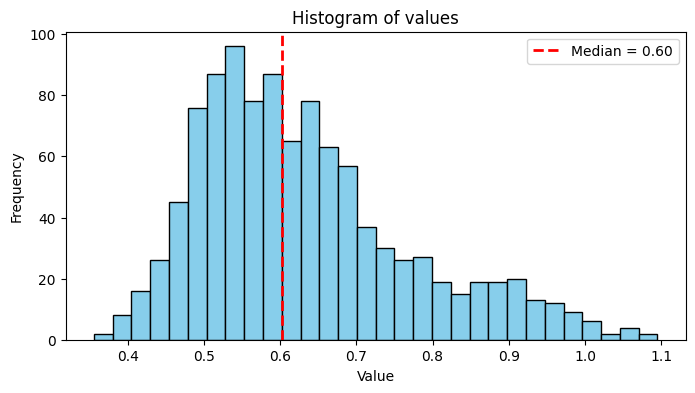

0.6201743

In [156]:
group_baseline = embeddings_df[embeddings_df['cell_line'] == 'Controls']
group_pert = embeddings_df[embeddings_df['cell_line'] == 'sALSPositiveCytoTDP43']

_compute_effect(group_baseline.iloc[:, :192].values, group_pert.iloc[:, :192].values)

group_baseline: (702, 192), group_pert: (175, 192)
median_dist_baseline: 0.3920145034790039; mean: 0.42760026454925537
median_dist_pert: 0.6502853631973267; mean: 0.6752488017082214


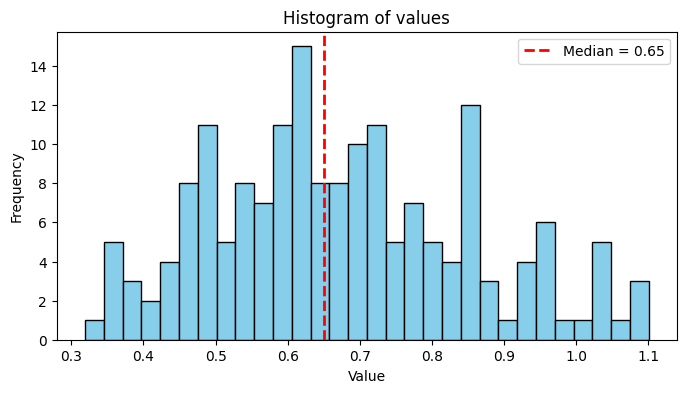

0.7301659

In [157]:
group_baseline = embeddings_df[embeddings_df['cell_line'] == 'Controls']
group_pert = embeddings_df[embeddings_df['cell_line'] == 'sALSNegativeCytoTDP43']

arr = group_pert.iloc[:, :192].values
# arr = arr[np.random.choice(arr.shape[0], size=1044, replace=True)]

_compute_effect(group_baseline.iloc[:, :192].values, arr)

In [172]:
from umap import UMAP

arr1 = embeddings_df[embeddings_df['cell_line'] == 'Controls'].iloc[:, :192].values
arr2 = embeddings_df[embeddings_df['cell_line'] == 'sALSPositiveCytoTDP43'].iloc[:, :192].values
arr3 = embeddings_df[embeddings_df['cell_line'] == 'sALSNegativeCytoTDP43'].iloc[:, :192].values    

# Concatenate into one array
X = np.vstack([arr1, arr2, arr3])

# Labels for coloring
labels = np.array(['Controls']*len(arr1) + ['sALS+']*len(arr2) + ['sALS-']*len(arr3))

# UMAP to 2D
reducer = UMAP(random_state=42)
X_umap = reducer.fit_transform(X)



/home/projects/hornsteinlab/Collaboration/NOVA/envs/nova/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Controls
sALS+
sALS-
[0.22745909 0.15215234]


<function matplotlib.pyplot.show(close=None, block=None)>

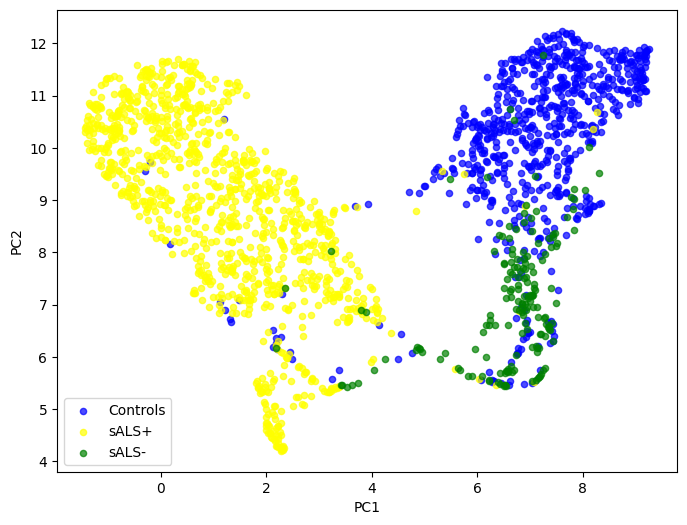

In [182]:
plt.figure(figsize=(8, 6))
for i, color in zip(['Controls', 'sALS+', 'sALS-'], ["blue", "yellow", "green"]):
    print(i)
    mask = labels == i
    plt.scatter(X_umap[mask, 0], X_umap[mask, 1], s=20, c=color, label=i, alpha=0.7)

print(reducer.explained_variance_ratio_)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show

Controls
sALS+
sALS-
[0.22745909 0.15215234]


<function matplotlib.pyplot.show(close=None, block=None)>

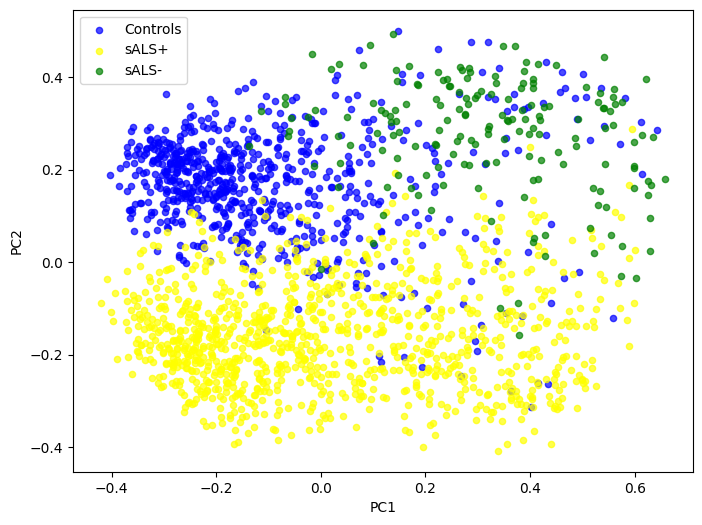

In [181]:
from sklearn.decomposition import PCA
reducer = PCA(n_components=2, random_state=42)
X_pca = reducer.fit_transform(X)



plt.figure(figsize=(8, 6))
for i, color in zip(['Controls', 'sALS+', 'sALS-'], ["blue", "yellow", "green"]):
    print(i)
    mask = labels == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=20, c=color, label=i, alpha=0.7)

print(reducer.explained_variance_ratio_)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show

In [183]:
from PIL import Image

img = Image.open("/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen/figures/neuronsDay8_new/effects/FUSRevertant_Untreated_vs_FUSHeterozygous_Untreated_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41/FUSHeterozygous_Untreated_vs_FUSRevertant_Untreated_forestplot_only_significant.png")


img.convert("RGBA").save("/home/projects/hornsteinlab/Collaboration/NOVA/tools/test_ef.pdf")

# Test distances between tiles from the same site VS tiles from different sites

In [ ]:
import os
import sys
os.environ['NOVA_HOME'] = '/home/projects/hornsteinlab/Collaboration/NOVA/'
os.environ['NOVA_DATA_HOME'] = '/home/projects/hornsteinlab/Collaboration/NOVA/input'

sys.path.insert(1, os.getenv("NOVA_HOME"))
print(f"NOVA_HOME: {os.getenv('NOVA_HOME')}")

from manuscript.effects_config import NeuronsEffectWTBaselineConfig
from src.effects.effects_config import EffectConfig
from src.embeddings.embeddings_utils import load_embeddings


class dNLSEffectConfig_Subset(EffectConfig):
    def __init__(self):
        super().__init__()
        self.INPUT_FOLDERS = ["batch1", 'batch2', 'batch4', 'batch5', 'batch6']
        self.EXPERIMENT_TYPE = 'dNLS'
        self.BASELINE = 'dNLS_Untreated'
        self.PERTURBATION = 'dNLS_DOX'

        self.MARKERS = ['LSM14A', 'DCP1A', 'TDP43'] #['ANXA11', 'CLTC', 'DCP1A', 'TDP43', 'LSM14A', 'FUS']
        self.CELL_LINES = ['dNLS']

class neuronsDay8_NEW_Subset(EffectConfig):
    def __init__(self):
        super().__init__()
        self.INPUT_FOLDERS = ["batch1", 'batch2', 'batch3', 'batch7', 'batch8', 'batch9']
        self.EXPERIMENT_TYPE = 'neuronsDay8_new'

        self.MARKERS = ['FUS']
        self.CELL_LINES = ['WT', 'FUSHomozygous']
        self.CONDITIONS = ['Untreated']


In [ ]:
output_folder_path = f"/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen"

config_data = dNLSEffectConfig_Subset()

embeddings, labels, paths = load_embeddings(output_folder_path, config_data)
print(f"Loaded embeddings: {embeddings.shape}, labels: {labels.shape}")

In [ ]:
embeddings_df = _prepare_embeddings_df(embeddings, labels, paths)

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

def compare_within_vs_across(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each (marker, batch, cell_line, condition) group, compute mean within-site
    and across-site Euclidean distances between embeddings.

    Args:
        df: DataFrame with embeddings and metadata.

    Returns:
        DataFrame with columns:
        marker, batch, cell_line, condition, mean_within, mean_across
    """
    results = []
    group_cols = ["marker", "batch", "cell_line", "condition"]
    

    for keys, group in df.groupby(group_cols):
        sites = group["site"].unique()
        embeddings = group[:192].to_numpy()

        mean_within_list, mean_across_list, mean_vs_single_site = [], [], []

        # iterate over sites
        for site in sites:
            site_embeds = group.loc[group["site"] == site].iloc[:, :192].to_numpy()

            # within-site distances
            if len(site_embeds) > 1:
                d_within = cdist(site_embeds, site_embeds, metric="euclidean")
                # take upper triangle (avoid 0 diagonal and double counting)
                tri_idx = np.triu_indices_from(d_within, k=1)
                mean_within_list.append(d_within[tri_idx].mean())

            # across-site distances
            other_embeds = group.loc[group["site"] != site].iloc[:, :192].to_numpy()
            d_across = cdist(site_embeds, other_embeds, metric="euclidean")
            mean_across_list.append(d_across.mean())

            # vs different single site
            other_sites = [s for s in sites if s != site] 
            random_site = np.random.choice(other_sites, size=1, replace=False)[0] 
            other_site_embeds = group.loc[group["site"] == random_site].iloc[:, :192].to_numpy() 
            d_other_site = cdist(site_embeds, other_site_embeds, metric="euclidean")
            mean_vs_single_site.append(d_other_site.mean())

        results.append({
            "marker": keys[0],
            "batch": keys[1],
            "cell_line": keys[2],
            "condition": keys[3],
            "mean_within": np.mean(mean_within_list) if mean_within_list else np.nan,
            "mean_across": np.mean(mean_across_list) if mean_across_list else np.nan,
            'mean_other_site': np.mean(mean_vs_single_site) if mean_vs_single_site else np.nan
        })

    return pd.DataFrame(results)


In [ ]:
distances_comparison_df = compare_within_vs_across(embeddings_df)
distances_comparison_df

# TODO: Calculate dist between conditions

In [ ]:
from src.analysis.analyzer_distances import AnalyzerDistances

d = AnalyzerDistances(config_data, output_folder_path, rep_effect=False, multiplexed=False, detailed_stats=False)
d.calculate(embeddings, labels)
d.features

In [ ]:
dist_df = d.features.copy()
dist_df

def filter_df(df: pd.DataFrame) -> pd.DataFrame:
    # 1. Keep only rows where label1 contains WT_Untreated and label2 contains FUSHomozygous
    # mask1 = df["label1"].str.contains("_FUSHomozygous_Untreated_", regex=False)
    # mask2 = df["label2"].str.contains("_WT_Untreated_", regex=False)
    # subset = df[mask1 & mask2].copy()
    subset = df.copy()

    subset["marker1"] = subset["label1"].str.split("_", n=1).str[0]
    subset["marker2"] = subset["label2"].str.split("_", n=1).str[0]
    

    # 3. Keep only rows where the batch tags match
    subset = subset[subset["marker1"] == subset["marker2"]]

    # 2. Extract the batch number from each label (assuming pattern like "_batch3_")
    subset["batch1"] = df["label1"].str.extract(r'_(batch\d+)_')
    subset["batch2"] = df["label2"].str.extract(r'_(batch\d+)_')

    # 3. Keep only rows where the batch tags match
    subset = subset[subset["batch1"] == subset["batch2"]]

    return subset.drop(columns=["batch1", "batch2"])

pd.set_option("display.max_rows", None)
filtered_dist_df = filter_df(dist_df)
filtered_dist_df.loc[filtered_dist_df['label1'].str.contains('LSM14A_dNLS_DOX') & filtered_dist_df['label2'].str.contains('LSM14A_dNLS_DOX'), ['label1', 'label2', 'total_pairs', 'p50']]

In [ ]:
filtered_dist_df.loc[filtered_dist_df['label1'].str.contains('LSM14A_dNLS_Untreated') & filtered_dist_df['label2'].str.contains('LSM14A_dNLS_Untreated'), ['label1', 'label2', 'total_pairs', 'p50']]

In [ ]:
filtered_dist_df.loc[filtered_dist_df['label1'].str.contains('LSM14A_dNLS_DOX') & filtered_dist_df['label2'].str.contains('LSM14A_dNLS_Untreated'), ['label1', 'label2', 'total_pairs', 'p50']]

In [ ]:
compare_within_vs_across(embeddings_df)

# Eval effect size

In [ ]:
import numpy as np

import statsmodels.stats.meta_analysis as smm
import pandas as pd

In [ ]:
dNLS_batch_effect = pd.read_csv("/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen/figures/dNLS/effects/dNLS_Untreated_vs_dNLS_DOX_batch1_batch2_batch4_batch5_batch6_all_reps_without_CD41/batch_effects.csv")
dNLS_combined_effect = pd.read_csv("/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen/figures/dNLS/effects/dNLS_Untreated_vs_dNLS_DOX_batch1_batch2_batch4_batch5_batch6_all_reps_without_CD41/combined_effects.csv")



In [ ]:
dNLS_batch_effect_LSM14A = dNLS_batch_effect[dNLS_batch_effect['marker'] == 'LSM14A']
dNLS_combined_effect_LSM14A = dNLS_combined_effect[dNLS_combined_effect['marker'] == 'LSM14A']
print(dNLS_batch_effect_LSM14A)


In [ ]:
effects = dNLS_batch_effect_LSM14A['effect_size'].values
variances = dNLS_batch_effect_LSM14A['variance'].values

meta_res = smm.combine_effects(effects, variances)
summary = meta_res.summary_frame()
summary


In [ ]:
meta_res.test_homogeneity()

In [ ]:
dNLS_batch_effect_TDP43 = dNLS_batch_effect[dNLS_batch_effect['marker'] == 'TDP43']
dNLS_combined_effect_TDP43 = dNLS_combined_effect[dNLS_combined_effect['marker'] == 'TDP43']
print(dNLS_batch_effect_TDP43)


effects = dNLS_batch_effect_TDP43['effect_size'].values
variances = dNLS_batch_effect_TDP43['variance'].values

meta_res = smm.combine_effects(effects, variances)
summary = meta_res.summary_frame()
summary


In [ ]:
meta_res.test_homogeneity()

# Testing Coefficient of Variation on tau

In [ ]:
dNLS_combined_effect['coefficient_of_variation_percentage'] = dNLS_combined_effect['tau2'] * 100.0 / np.abs(dNLS_combined_effect['combined_effect'])

In [ ]:
dNLS_combined_effect[(dNLS_combined_effect['coefficient_of_variation_percentage'] <= 20) & (dNLS_combined_effect['adj_pvalue'] <= 0.05)].sort_values(by='combined_effect', ascending=False).reset_index(drop=True)

# Extracting results

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import sys
os.environ['NOVA_HOME'] = '/home/projects/hornsteinlab/Collaboration/NOVA/'
os.environ['NOVA_DATA_HOME'] = '/home/projects/hornsteinlab/Collaboration/NOVA/input'   
sys.path.insert(1, os.getenv("NOVA_HOME"))
print(f"NOVA_HOME: {os.getenv('NOVA_HOME')}")

from manuscript.plot_config import PlotConfig

NOVA_HOME: /home/projects/hornsteinlab/Collaboration/NOVA/


In [ ]:
# coefficient_of_variation_percentage_threshold = 20

In [2]:
def get_results(experiment_type, folder_name, batch_effect_filename="batch_effects.csv"):
    batch_effect = pd.read_csv(f"/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen/figures/{experiment_type}/effects/{folder_name}/{batch_effect_filename}")
    combined_effect = pd.read_csv(f"/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen/figures/{experiment_type}/effects/{folder_name}/combined_effects.csv")

    # combined_effect['coefficient_of_variation_percentage'] = combined_effect['tau2'] * 100.0 / np.abs(combined_effect['combined_effect'])

    # return combined_effect, combined_effect[(combined_effect['coefficient_of_variation_percentage'] <= 20) & (combined_effect['adj_pvalue'] <= 0.05)].sort_values(by='combined_effect', ascending=False).reset_index(drop=True), batch_effect

    return batch_effect, combined_effect

def get_results_concat(experiment_type, folder_names, batch_effect_filename="batch_effects.csv"):
    batch_effects, combined_effects = [], []
    
    for folder_name in folder_names:
        batch_effect, combined_effect = get_results(experiment_type, folder_name, batch_effect_filename)
        batch_effects.append(batch_effect)
        combined_effects.append(combined_effect)

    batch_effects = pd.concat(batch_effects, ignore_index=True)
    combined_effects = pd.concat(combined_effects, ignore_index=True)

    return batch_effects, combined_effects

def filter_by_markers(batch_effect, combined_effect, markers):
    batch_effect_filtered = batch_effect[batch_effect['marker'].isin(markers)].copy()
    combined_effect_filtered = combined_effect[combined_effect['marker'].isin(markers)].copy()

    return batch_effect_filtered, combined_effect_filtered

def get_shared_markers(combined_effects):
    sig_df = combined_effects[combined_effects["adj_pvalue"] <= 0.05]
    summary_df = sig_df.pivot_table(
        index="marker",
        columns="pert",
        values=["adj_pvalue", "combined_effect", "I2"]
    )
    
    return summary_df.reset_index()


In [ ]:
# combined_effect, combined_effect_filtered, batch_effect = get_results("AlyssaCoyne_new", "batch1_all_reps_without_CD41", "effects.csv")
# markers = combined_effect[(combined_effect['pert'] == 'C9') & (combined_effect['adj_pvalue'] <= 0.05)].sort_values(by='combined_effect', ascending=False).reset_index(drop=True)['marker'].tolist()
# batch_effect[(batch_effect['pert']=='C9') & (batch_effect['marker'].isin(markers))][batch_effect['marker'] == 'Nup98']
# # combined_effect[(combined_effect['adj_pvalue'] <= 0.05) & (combined_effect['pert'] == 'C9')].sort_values(by='combined_effect', ascending=False).reset_index(drop=True)

In [5]:
# batch_effect, combined_effect = get_results("NIH", "WT_Untreated_vs_WT_stress_batch1_batch2_batch3_all_reps_without_CD41")
# batch_effect_filtered, combined_effect_filtered = filter_by_markers(batch_effect, combined_effect, union_sig_markers)

# combined_effect_filtered

In [41]:
union_sig_markers = ['FUS', 'LAMP1', 'PEX14', 'PURA', 'NEMO', 'SNCA', 'PML', 'TIA1', 'DCP1A','LSM14A',\
                                 'TOMM20', 'HNRNPA1','TDP43', 'ANXA11', 'GM130', 'Calreticulin', 'NONO', 'Tubulin', 'PSD95']

Combined effects shape: (145, 19), batch effects shape: (865, 10)
Filtering by markers: ['FUS', 'LAMP1', 'PEX14', 'PURA', 'NEMO', 'SNCA', 'PML', 'TIA1', 'DCP1A', 'LSM14A', 'TOMM20', 'HNRNPA1', 'TDP43', 'ANXA11', 'GM130', 'Calreticulin', 'NONO', 'Tubulin', 'PSD95']
Combined effects shape: (95, 19), batch effects shape: (565, 10)


/tmp/ipykernel_987804/3864929010.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_df['organelle_name'] = sig_df['marker'].map(lambda x: plt_config.COLOR_MAPPINGS_MARKERS[x][plt_config.MAPPINGS_ALIAS_KEY])


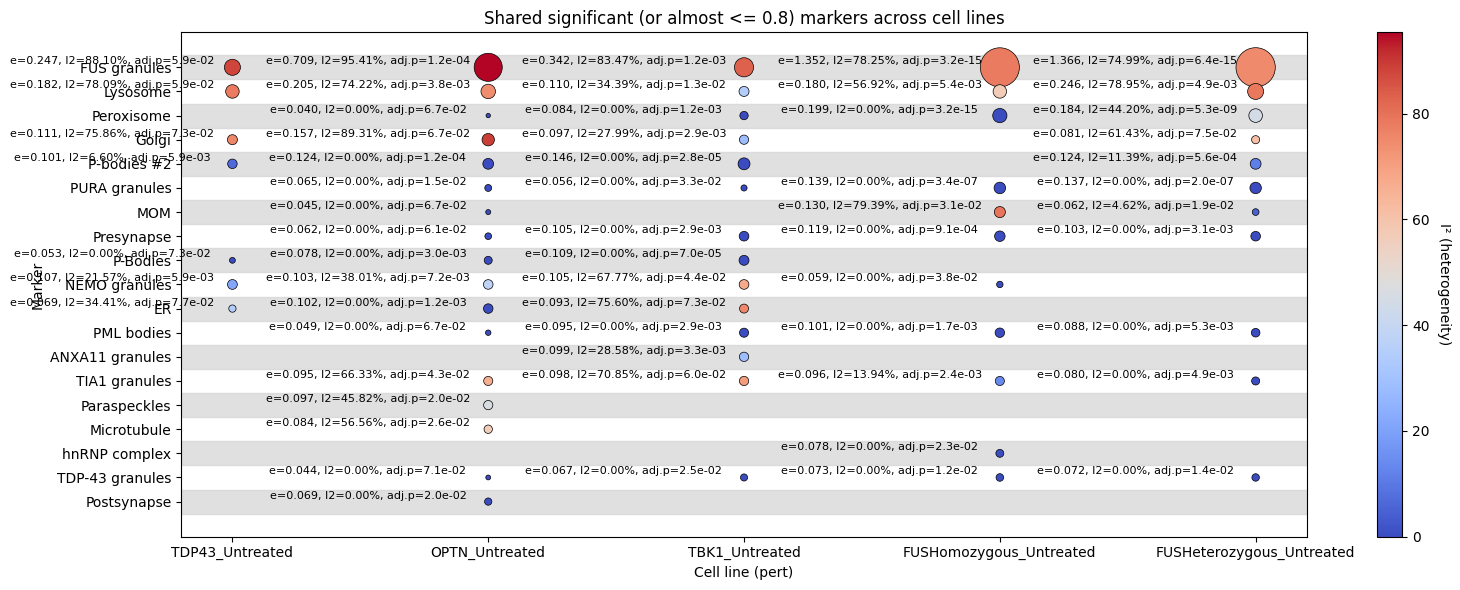

In [60]:


folders = [f"WT_Untreated_vs_{pert}_Untreated_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41" for pert in ["TDP43", "OPTN", "TBK1", "FUSHomozygous", 'FUSHeterozygous']]
batch_effects, combined_effects = get_results_concat("neuronsDay8_new", folders)

print(f"Combined effects shape: {combined_effects.shape}, batch effects shape: {batch_effects.shape}")

print("Filtering by markers:", union_sig_markers)
batch_effects_filtered, combined_effects_filtered = filter_by_markers(batch_effects, combined_effects, union_sig_markers)
print(f"Combined effects shape: {combined_effects_filtered.shape}, batch effects shape: {batch_effects_filtered.shape}")

# get_shared_markers(combined_effects_filtered)
sig_df = combined_effects_filtered[combined_effects_filtered["adj_pvalue"] <= 0.08]
# sig_df = sig_df[sig_df["combined_effect"] >= 0.1]
plt_config = PlotConfig()
sig_df['organelle_name'] = sig_df['marker'].map(lambda x: plt_config.COLOR_MAPPINGS_MARKERS[x][plt_config.MAPPINGS_ALIAS_KEY])

marker_order = (
    sig_df.groupby("organelle_name")["combined_effect"]
    .max()   # or .mean() if you prefer
    .sort_values(ascending=False)
    .index
)


plt.figure(figsize=(16, 6))

for i, marker in enumerate(marker_order):
    if i % 2 == 0:  # every other row
        plt.axhspan(i - 0.5, i + 0.5, color="lightgray", alpha=0.7, zorder=0)

scatter = sns.scatterplot(
    data=sig_df,
    x="pert",
    y=pd.Categorical(sig_df["organelle_name"], categories=marker_order, ordered=True),
    size="combined_effect",
    hue="I2",
    sizes=(10, 800),      # min/max bubble size
    palette="coolwarm",   # blue (low I²) → red (high I²)
    edgecolor="black",
    linewidth=0.5,
    zorder=2
)

ax = plt.gca()
xticks = dict(zip(ax.get_xticklabels(), ax.get_xticks()))
yticks = dict(zip(marker_order, range(len(marker_order))))

# Annotate bubbles with effect size and I²
for _, row in sig_df.iterrows():
    x = ax.get_xticks()[list(sig_df["pert"].unique()).index(row["pert"])]
    y = marker_order.get_loc(row["organelle_name"])
    plt.text(
        x-0.47,
        y-0.25,
        f"e={row['combined_effect']:.3f}, I2={row['I2']:.2f}%, adj.p={row['adj_pvalue']:.1e}",
        ha="center", va="center",
        fontsize=8, color="black"
    )

# --- Colorbar for I² ---
norm = plt.Normalize(sig_df["I2"].min(), sig_df["I2"].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
scatter.get_legend().remove()  # remove default legend

cbar = plt.colorbar(sm)
cbar.set_label("I² (heterogeneity)", rotation=270, labelpad=15)

plt.title("Shared significant (or almost <= 0.8) markers across cell lines")
plt.xlabel("Cell line (pert)")
plt.ylabel("Marker")

plt.tight_layout()
plt.show()


In [54]:
sig_df[sig_df['marker'] == 'PURA'].loc[:,['marker', 'baseline', 'pert', 'combined_effect', 'adj_pvalue']]

,marker,baseline,pert,combined_effect,adj_pvalue
48,PURA,WT_Untreated,OPTN_Untreated,0.064794,1.464293e-02
77,PURA,WT_Untreated,TBK1_Untreated,0.056077,3.286967e-02
106,PURA,WT_Untreated,FUSHomozygous_Untreated,0.138960,3.419111e-07
135,PURA,WT_Untreated,FUSHeterozygous_Untreated,0.136890,1.950051e-07


Combined effects shape: (58, 19), batch effects shape: (346, 10)
Filtering by markers: ['FUS', 'LAMP1', 'PEX14', 'PURA', 'NEMO', 'SNCA', 'PML', 'TIA1', 'DCP1A', 'LSM14A', 'TOMM20', 'HNRNPA1', 'TDP43', 'ANXA11', 'GM130', 'Calreticulin', 'NONO', 'Tubulin', 'PSD95']
Combined effects shape: (38, 19), batch effects shape: (226, 10)


/tmp/ipykernel_987804/1650052547.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_df2['organelle_name'] = sig_df2['marker'].map(lambda x: plt_config.COLOR_MAPPINGS_MARKERS[x][plt_config.MAPPINGS_ALIAS_KEY])


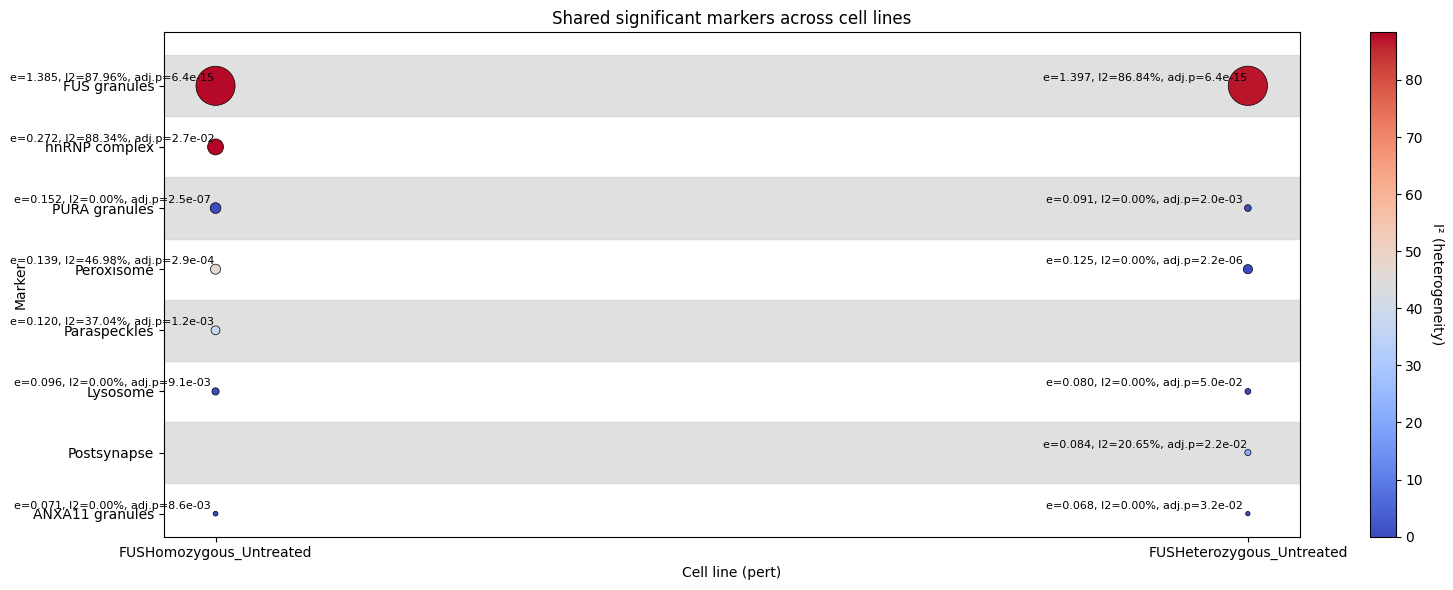

In [61]:
folders = [f"FUSRevertant_Untreated_vs_{pert}_Untreated_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41" for pert in ["FUSHomozygous", "FUSHeterozygous"]]
batch_effects, combined_effects = get_results_concat("neuronsDay8_new", folders)

print(f"Combined effects shape: {combined_effects.shape}, batch effects shape: {batch_effects.shape}")

print("Filtering by markers:", union_sig_markers)
batch_effects_filtered, combined_effects_filtered = filter_by_markers(batch_effects, combined_effects, union_sig_markers)
print(f"Combined effects shape: {combined_effects_filtered.shape}, batch effects shape: {batch_effects_filtered.shape}")

# get_shared_markers(combined_effects_filtered)
sig_df2 = combined_effects_filtered[combined_effects_filtered["adj_pvalue"] < 0.05]
# sig_df = combined_effects_filtered[combined_effects_filtered["combined_effect"] >= 0.1]
plt_config = PlotConfig()
sig_df2['organelle_name'] = sig_df2['marker'].map(lambda x: plt_config.COLOR_MAPPINGS_MARKERS[x][plt_config.MAPPINGS_ALIAS_KEY])

marker_order = (
    sig_df2.groupby("organelle_name")["combined_effect"]
    .max()   # or .mean() if you prefer
    .sort_values(ascending=False)
    .index
)


plt.figure(figsize=(16, 6))

for i, marker in enumerate(marker_order):
    if i % 2 == 0:  # every other row
        plt.axhspan(i - 0.5, i + 0.5, color="lightgray", alpha=0.7, zorder=0)

scatter = sns.scatterplot(
    data=sig_df2,
    x="pert",
    y=pd.Categorical(sig_df2["organelle_name"], categories=marker_order, ordered=True),
    size="combined_effect",
    hue="I2",
    sizes=(10, 800),      # min/max bubble size
    palette="coolwarm",   # blue (low I²) → red (high I²)
    edgecolor="black",
    linewidth=0.5,
    zorder=2
)

ax = plt.gca()
xticks = dict(zip(ax.get_xticklabels(), ax.get_xticks()))
yticks = dict(zip(marker_order, range(len(marker_order))))

# Annotate bubbles with effect size and I²
for _, row in sig_df2.iterrows():
    x = ax.get_xticks()[list(sig_df2["pert"].unique()).index(row["pert"])]
    y = marker_order.get_loc(row["organelle_name"])
    plt.text(
        x-0.1,
        y-0.13,
        f"e={row['combined_effect']:.3f}, I2={row['I2']:.2f}%, adj.p={row['adj_pvalue']:.1e}",
        ha="center", va="center",
        fontsize=8, color="black"
    )

# --- Colorbar for I² ---
norm = plt.Normalize(sig_df2["I2"].min(), sig_df2["I2"].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
scatter.get_legend().remove()  # remove default legend

cbar = plt.colorbar(sm)
cbar.set_label("I² (heterogeneity)", rotation=270, labelpad=15)

plt.title("Shared significant markers across cell lines")
plt.xlabel("Cell line (pert)")
plt.ylabel("Marker")

plt.tight_layout()
plt.show()


In [ ]:
"FUS(V), Peroxisome(V), Lysosome(V), PURA(V), hnRNP complex"


In [87]:
sig_selected = sig_df[sig_df['pert'] == 'FUSHomozygous_Untreated'].loc[sig_df['adj_pvalue']<=0.05,['marker', 'baseline', 'pert', 'combined_effect', 'adj_pvalue', 'I2', 'tau2', 'tau2_ci_low', 'tau2_ci_upp']]
sig2_selected = sig_df2[sig_df2['pert'] == 'FUSHomozygous_Untreated'].loc[sig_df2['adj_pvalue']<=0.05,['marker', 'baseline', 'pert', 'combined_effect', 'adj_pvalue', 'I2','tau2', 'tau2_ci_low', 'tau2_ci_upp']]

shared_markers = list(set(sig_selected['marker']).intersection(set(sig2_selected['marker'])))

sig_selected[sig_selected['marker'].isin(shared_markers)].sort_values(by='combined_effect', ascending=False)
# sig2_selected[sig2_selected['marker'].isin(shared_markers)].sort_values(by='combined_effect', ascending=False)

,marker,baseline,pert,combined_effect,adj_pvalue,I2,tau2,tau2_ci_low,tau2_ci_upp
93,FUS,WT_Untreated,FUSHomozygous_Untreated,1.351963,3.219647e-15,78.251638,0.014179,0.001861,0.105933
103,PEX14,WT_Untreated,FUSHomozygous_Untreated,0.199112,3.219647e-15,0.000000,0.000000,0.000000,0.010617
98,LAMP1,WT_Untreated,FUSHomozygous_Untreated,0.180038,5.444834e-03,56.917216,0.012085,0.000000,0.093128
106,PURA,WT_Untreated,FUSHomozygous_Untreated,0.138960,3.419111e-07,0.000000,0.000000,0.000000,0.012051
96,HNRNPA1,WT_Untreated,FUSHomozygous_Untreated,0.077850,2.255336e-02,0.000000,0.000000,0.000000,0.013205


In [14]:
# AlyssaNew

alyssa_new_batch_effect, alyssa_new_combined_effect = get_results("AlyssaCoyne_new", "batch1_all_reps_without_CD41", "combined_effects.csv")
# alyssa_new_batch_effect_filtered, alyssa_new_combined_effect_filtered = filter_by_markers(alyssa_new_batch_effect, alyssa_new_combined_effect)
# alyssa_new_combined_effect = alyssa_new_combined_effect[alyssa_new_combined_effect['adj_pvalue'] <= 0.05]
alyssa_new_combined_effect = alyssa_new_combined_effect[alyssa_new_combined_effect['marker'] == 'DCP1A']
alyssa_new_combined_effect[['marker', 'baseline', 'pert', 'combined_effect', 'adj_pvalue']].sort_values(by='combined_effect', ascending=False).reset_index(drop=True)

,marker,baseline,pert,combined_effect,adj_pvalue
0,DCP1A,Ctrl,C9,0.962984,1.981137e-08
1,DCP1A,Ctrl,SALSNegative,0.594011,8.227169e-04
2,DCP1A,Ctrl,SALSPositive,0.544002,7.220133e-02


# Extract results for text

In [1]:
import pandas as pd

def get_txt(pooled_effect_size, CI, adj_p, Q, p_heterogeneity, I2, tau2, tau2_CI, k, detailed=False):
    if detailed:
        return f"combined effect size={pooled_effect_size:.3f}, %95 CI: {CI[0]:.3f}:{CI[1]:.3f}, adj. p={adj_p}; Q({k-1})={Q:.2f}, p={p_heterogeneity}, I²={I2:.2f}, τ²={tau2} (95% profile likelihood CI: {tau2_CI[0]}:{tau2_CI[1]})"
    return f"combined effect size={pooled_effect_size:.3f}, adj. p={adj_p}; heterogeneity: I²={I2:.2f}, τ²={tau2} (95% CI=[{tau2_CI[0]},{tau2_CI[1]}])"

def get_results(experiment_type, folder_name, batch_effect_filename="batch_effects.csv"):
    batch_effect = pd.read_csv(f"/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen/figures/{experiment_type}/effects/{folder_name}/{batch_effect_filename}")
    combined_effect = pd.read_csv(f"/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen/figures/{experiment_type}/effects/{folder_name}/combined_effects.csv")

    return combined_effect, batch_effect

def convert_pvalue_to_asterisks(pval:float)->str:
    if pval <= 0.0001:
        return '****'
    elif pval <= 0.001:
        return '***'
    elif pval <= 0.01:
        return '**'
    elif pval <= 0.05:
        return '*'
    else:
        return ''

def get_info_for_marker(marker, combined_effect, batch_effect):
    combined_effect_marker = combined_effect[combined_effect['marker'] == marker]
    batch_effect_marker = batch_effect[batch_effect['marker'] == marker]
    pooled_effect_size = combined_effect_marker['combined_effect'].values[0]
    CI = (combined_effect_marker['ci_low'].values[0], combined_effect_marker['ci_upp'].values[0])
    adj_p = combined_effect_marker['adj_pvalue'].values[0]
    Q = combined_effect_marker['Q'].values[0]
    p_heterogeneity = combined_effect_marker['p_heterogeneity'].values[0]
    I2 = combined_effect_marker['I2'].values[0]
    tau2 = combined_effect_marker['tau2'].values[0]
    tau2_CI = (combined_effect_marker['tau2_ci_low'].values[0], combined_effect_marker['tau2_ci_upp'].values[0])
    k = len(batch_effect_marker)

    return pooled_effect_size, CI, adj_p, Q, p_heterogeneity, I2, tau2, tau2_CI, k

In [ ]:
experiment_type = "neuronsDay8_new"
folder_name = "WT_Untreated_vs_TBK1_Untreated_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41"
marker_name = "FUS"
combined_effect, batch_effect = get_results(experiment_type, folder_name)
stats = get_info_for_marker(marker_name, combined_effect, batch_effect)
print(f"experiment: {experiment_type}, folder: {folder_name}")
print(f"marker: {marker_name}")

print(get_txt(*stats))
pd.DataFrame([stats], columns=['pooled_effect_size', 'CI', 'adj_p', 'Q', 'p_heterogeneity', 'I2', 'tau2', 'tau2_CI', 'k'])

In [19]:
experiment_type = "neuronsDay8_new"
all_stats_df = []

for baseline in ["WT_Untreated", "FUSRevertant_Untreated"]:
    for pert in ["TBK1_Untreated", "OPTN_Untreated", "TDP43_Untreated", "FUSHomozygous_Untreated", "FUSHeterozygous_Untreated"]:
        folder_name = f"{baseline}_vs_{pert}_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41"
        try:
            combined_effect, batch_effect = get_results(experiment_type, folder_name)
        except FileNotFoundError:
            print(f"Skipping missing folder: {folder_name}")
            continue
        print(f"experiment: {experiment_type}, folder: {folder_name}, baseline: {baseline}, pert: {pert}")

        combined_effect = combined_effect[combined_effect['adj_pvalue'] <= 0.05]

        stats_df = combined_effect[['marker', 'baseline', 'pert', 'adj_pvalue']].copy()
        all_stats_df.append(stats_df)

all_stats_df = pd.concat(all_stats_df, ignore_index=True)
all_stats_df['asterisks'] = all_stats_df['adj_pvalue'].map(convert_pvalue_to_asterisks)
all_stats_df.to_csv("/home/projects/hornsteinlab/Collaboration/NOVA/tools/neuronsDay8_new_adjPvalues_asterisks.csv", index=False)

experiment: neuronsDay8_new, folder: WT_Untreated_vs_TBK1_Untreated_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41, baseline: WT_Untreated, pert: TBK1_Untreated
experiment: neuronsDay8_new, folder: WT_Untreated_vs_OPTN_Untreated_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41, baseline: WT_Untreated, pert: OPTN_Untreated
experiment: neuronsDay8_new, folder: WT_Untreated_vs_TDP43_Untreated_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41, baseline: WT_Untreated, pert: TDP43_Untreated
experiment: neuronsDay8_new, folder: WT_Untreated_vs_FUSHomozygous_Untreated_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41, baseline: WT_Untreated, pert: FUSHomozygous_Untreated
experiment: neuronsDay8_new, folder: WT_Untreated_vs_FUSHeterozygous_Untreated_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41, baseline: WT_Untreated, pert: FUSHeterozygous_Untreated
Skipping missing folder: FUSRevertant_Untreated_vs_TBK1_Untreated_ba

In [22]:
experiment_type = "AlyssaCoyne_new"
all_stats_df = []

folder_name = f"batch1_all_reps_without_CD41"
combined_effect, batch_effect = get_results(experiment_type, folder_name)
print(f"experiment: {experiment_type}, folder: {folder_name}")

combined_effect = combined_effect[combined_effect['adj_pvalue'] <= 0.05]

stats_df = combined_effect[['marker', 'baseline', 'pert', 'adj_pvalue']].copy()
all_stats_df.append(stats_df)

all_stats_df = pd.concat(all_stats_df, ignore_index=True)
all_stats_df['asterisks'] = all_stats_df['adj_pvalue'].map(convert_pvalue_to_asterisks)
all_stats_df
all_stats_df.to_csv("/home/projects/hornsteinlab/Collaboration/NOVA/tools/AlyssaCoyne_new_adjPvalues_asterisks.csv", index=False)

experiment: AlyssaCoyne_new, folder: batch1_all_reps_without_CD41


# Extrat stats for sup materials

In [9]:
import numpy as np
import pandas as pd
import os
import sys

os.environ["NOVA_HOME"] = "/home/projects/hornsteinlab/Collaboration/NOVA/"
sys.path.insert(1, os.getenv("NOVA_HOME"))
print(os.getenv("NOVA_HOME"))


from src.figures.figures_config import FigureConfig
import matplotlib.colors as mcolors

from manuscript.plot_config import PlotConfig

/home/projects/hornsteinlab/Collaboration/NOVA/


In [34]:

def get_combined_effects(experiment_type, folder_name):
    combined_effect = pd.read_csv(f"/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen/figures/{experiment_type}/effects/{folder_name}/combined_effects.csv")

    combined_effect = combined_effect[['marker', 'baseline', 'pert', 'combined_effect', 'combined_se', 'ci_low', 'ci_upp', 'pvalue', 'adj_pvalue',  'I2', 'Q', 'tau2', 'tau2_ci_low', 'tau2_ci_upp']]
    combined_effect.insert(0, 'organelle_name', combined_effect['marker'].map(lambda x: PlotConfig().COLOR_MAPPINGS_MARKERS[x][PlotConfig().MAPPINGS_ALIAS_KEY]))
    
    combined_effect['organelle_name'].replace({'P-bodies #2': 'P-bodies'}, inplace=True)


    return combined_effect

def get_combined_effects_ALS(experiment_type, base, pert):
    return  get_combined_effects(experiment_type, f"{base}_Untreated_vs_{pert}_Untreated_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41")

def save_table(df:pd.DataFrame, filename:str):
    folder_path = "/home/projects/hornsteinlab/Collaboration/NOVA/manuscript/tables_of_stats_sup_material"
    df.to_csv(os.path.join(folder_path, filename), index=False)
    print(f"Saved table to {os.path.join(folder_path, filename)}")


In [35]:
NIH_df = get_combined_effects("NIH", "WT_Untreated_vs_WT_stress_batch1_batch2_batch3_all_reps_without_CD41")
save_table(NIH_df, "d8_stressed.csv")
NIH_df

Saved table to /home/projects/hornsteinlab/Collaboration/NOVA/manuscript/tables_of_stats_sup_material/d8_stressed.csv


/tmp/ipykernel_987804/1052770209.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_effect['organelle_name'].replace({'P-bodies #2': 'P-bodies'}, inplace=True)


,organelle_name,marker,baseline,pert,combined_effect,combined_se,ci_low,ci_upp,pvalue,adj_pvalue,I2,Q,tau2,tau2_ci_low,tau2_ci_upp
0,ANXA11 granules,ANAX11,WT_Untreated,WT_stress,0.002019,0.044037,-0.084293,0.088331,4.817151e-01,5.009837e-01,0.000000,0.005575,0.000000,0.000000,0.033992
1,Coated vesicles,CLTC,WT_Untreated,WT_stress,0.010412,0.042484,-0.072854,0.093679,4.031949e-01,4.557856e-01,0.000000,0.144816,0.000000,0.000000,0.034040
2,ER,Calreticulin,WT_Untreated,WT_stress,0.022163,0.055787,-0.087178,0.131504,3.455828e-01,4.291377e-01,0.000000,0.645670,0.000000,0.000000,0.084849
3,Nucleus,DAPI,WT_Untreated,WT_stress,-0.021158,0.017658,-0.055767,0.013451,8.845835e-01,8.845835e-01,0.000000,0.185068,0.000000,0.000000,0.005988
4,P-Bodies,DCP1A,WT_Untreated,WT_stress,0.182025,0.062023,0.060463,0.303588,1.668715e-03,7.231099e-03,24.910952,2.663504,0.002757,0.000000,0.196584
5,FMRP granules,FMRP,WT_Untreated,WT_stress,0.421303,0.211081,0.007592,0.835014,2.297083e-02,7.465521e-02,95.452737,43.982502,0.126836,0.024309,2.336672
6,FUS granules,FUS,WT_Untreated,WT_stress,0.117820,0.067588,-0.014650,0.250290,4.064880e-02,1.068798e-01,41.403186,3.413155,0.006088,0.000000,0.232967
7,Stress granules,G3BP1,WT_Untreated,WT_stress,0.702550,0.124586,0.458366,0.946733,8.547855e-09,2.222442e-07,87.973495,16.629936,0.040639,0.005014,0.810626
8,Golgi,GM130,WT_Untreated,WT_stress,0.085323,0.049553,-0.011800,0.182446,4.254988e-02,1.068798e-01,0.000000,0.107282,0.000000,0.000000,0.045297
9,Transport machinery,KIF5A,WT_Untreated,WT_stress,0.012378,0.043538,-0.072955,0.097712,3.880862e-01,4.557856e-01,0.000000,0.135870,0.000000,0.000000,0.035557


In [36]:
neuronsDay8_new_df = pd.concat([get_combined_effects_ALS("neuronsDay8_new", "WT", pert) for pert in ["TBK1", "OPTN", "TDP43", "FUSHomozygous", "FUSHeterozygous"]], ignore_index=True)
neuronsDay8_new_df = pd.concat([neuronsDay8_new_df] + [get_combined_effects_ALS("neuronsDay8_new", "FUSRevertant", pert) for pert in ["FUSHomozygous", "FUSHeterozygous"]], ignore_index=True)
save_table(neuronsDay8_new_df, "d8_ALS.csv")
neuronsDay8_new_df

/tmp/ipykernel_987804/1052770209.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_effect['organelle_name'].replace({'P-bodies #2': 'P-bodies'}, inplace=True)
/tmp/ipykernel_987804/1052770209.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df

Saved table to /home/projects/hornsteinlab/Collaboration/NOVA/manuscript/tables_of_stats_sup_material/d8_ALS.csv


,organelle_name,marker,baseline,pert,combined_effect,combined_se,ci_low,ci_upp,pvalue,adj_pvalue,I2,Q,tau2,tau2_ci_low,tau2_ci_upp
0,ANXA11 granules,ANXA11,WT_Untreated,TBK1_Untreated,0.099056,0.031731,0.036864,0.161248,0.000899,0.003259,28.581858,7.001022,0.002416,0.000000,0.023217
1,Coated vesicles,CLTC,WT_Untreated,TBK1_Untreated,0.027039,0.052243,-0.075356,0.129434,0.302382,0.313181,75.291072,20.235601,0.011921,0.001887,0.073804
2,ER,Calreticulin,WT_Untreated,TBK1_Untreated,0.093474,0.052633,-0.009684,0.196632,0.037869,0.073213,75.604154,20.495293,0.012515,0.001888,0.074858
3,Nucleus,DAPI,WT_Untreated,TBK1_Untreated,0.011059,0.018909,-0.026002,0.048121,0.279320,0.300010,63.986833,13.883811,0.001351,0.000005,0.009429
4,P-Bodies,DCP1A,WT_Untreated,TBK1_Untreated,0.108978,0.024632,0.060700,0.157255,0.000005,0.000070,0.000000,1.594887,0.000000,0.000000,0.005813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,TDP-43 granules,TDP43,FUSRevertant_Untreated,FUSHeterozygous_Untreated,0.018304,0.029595,-0.039702,0.076310,0.268134,0.370280,0.000000,4.775373,0.000000,0.000000,0.019261
199,TIA1 granules,TIA1,FUSRevertant_Untreated,FUSHeterozygous_Untreated,-0.019124,0.024659,-0.067456,0.029207,0.780991,0.821185,0.000000,1.763859,0.000000,0.000000,0.006186
200,MOM,TOMM20,FUSRevertant_Untreated,FUSHeterozygous_Untreated,-0.021531,0.026373,-0.073221,0.030159,0.792869,0.821185,0.000000,3.380527,0.000000,0.000000,0.010341
201,Microtubule,Tubulin,FUSRevertant_Untreated,FUSHeterozygous_Untreated,0.026122,0.024530,-0.021956,0.074201,0.143462,0.260025,0.000000,1.895880,0.000000,0.000000,0.006579


In [37]:
dNLS_df = get_combined_effects("dNLS", "dNLS_Untreated_vs_dNLS_DOX_batch1_batch2_batch4_batch5_batch6_all_reps_without_CD41")
save_table(dNLS_df, "dNLS.csv")
dNLS_df

Saved table to /home/projects/hornsteinlab/Collaboration/NOVA/manuscript/tables_of_stats_sup_material/dNLS.csv


/tmp/ipykernel_987804/1052770209.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_effect['organelle_name'].replace({'P-bodies #2': 'P-bodies'}, inplace=True)


,organelle_name,marker,baseline,pert,combined_effect,combined_se,ci_low,ci_upp,pvalue,adj_pvalue,I2,Q,tau2,tau2_ci_low,tau2_ci_upp
0,ANXA11 granules,ANXA11,dNLS_Untreated,dNLS_DOX,0.032598,0.019875,-0.006357,0.071553,5.048923e-02,1.409966e-01,0.000000,0.528324,0.000000,0.000000,0.003779
1,Coated vesicles,CLTC,dNLS_Untreated,dNLS_DOX,0.088853,0.048268,-0.005751,0.183458,3.282362e-02,1.189856e-01,67.768521,12.410228,0.007974,0.000000,0.066502
2,ER,Calreticulin,dNLS_Untreated,dNLS_DOX,0.037792,0.026513,-0.014173,0.089756,7.702179e-02,1.718178e-01,0.000000,0.496411,0.000000,0.000000,0.007602
3,Nucleus,DAPI,dNLS_Untreated,dNLS_DOX,-0.011346,0.013544,-0.037892,0.015201,7.988899e-01,8.274217e-01,0.000000,1.084718,0.000000,0.000000,0.002168
4,P-Bodies,DCP1A,dNLS_Untreated,dNLS_DOX,0.155786,0.035955,0.085316,0.226256,7.360213e-06,7.114872e-05,0.000000,0.355312,0.000000,0.000000,0.028415
5,FMRP granules,FMRP,dNLS_Untreated,dNLS_DOX,-0.018024,0.026843,-0.070636,0.034588,7.490343e-01,8.274217e-01,0.000000,0.491351,0.000000,0.000000,0.006936
6,FUS granules,FUS,dNLS_Untreated,dNLS_DOX,0.104426,0.133731,-0.157681,0.366533,2.174402e-01,3.503203e-01,76.794815,17.237527,0.079830,0.000000,0.512511
7,Stress granules,G3BP1,dNLS_Untreated,dNLS_DOX,0.002346,0.026250,-0.049104,0.053796,4.643996e-01,6.492522e-01,0.000000,1.291321,0.000000,0.000000,0.008416
8,Golgi,GM130,dNLS_Untreated,dNLS_DOX,0.055659,0.044332,-0.031229,0.142547,1.046461e-01,2.123378e-01,48.112162,7.708936,0.005418,0.000000,0.053839
9,hnRNP complex,HNRNPA1,dNLS_Untreated,dNLS_DOX,-0.013383,0.057256,-0.125603,0.098836,5.924094e-01,7.809033e-01,0.000000,2.038745,0.000000,0.000000,0.064299


In [38]:
alyssaNew_df = get_combined_effects("AlyssaCoyne_new", "batch1_all_reps_without_CD41")
save_table(alyssaNew_df, "patient_derived.csv")
alyssaNew_df

Saved table to /home/projects/hornsteinlab/Collaboration/NOVA/manuscript/tables_of_stats_sup_material/patient_derived.csv


/tmp/ipykernel_987804/1052770209.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_effect['organelle_name'].replace({'P-bodies #2': 'P-bodies'}, inplace=True)


,organelle_name,marker,baseline,pert,combined_effect,combined_se,ci_low,ci_upp,pvalue,adj_pvalue,I2,Q,tau2,tau2_ci_low,tau2_ci_upp
0,ANXA11 granules,ANXA11,Ctrl,C9,0.768739,0.162592,0.450065,1.087412,1.133511e-06,5.727212e-06,0.000000,1.140013,0.000000,0.000000,0.840098
1,Coated vesicles,CLTC,Ctrl,C9,1.205762,0.149332,0.913076,1.498448,3.330669e-16,6.394885e-15,0.000000,0.300928,0.000000,0.000000,0.457511
2,Calnexin,Calnexin,Ctrl,C9,0.480910,0.158631,0.169999,0.791820,1.216183e-03,3.891786e-03,12.796466,2.293485,0.008251,0.000000,1.440436
3,ER,Calreticulin,Ctrl,C9,1.098589,0.132473,0.838946,1.358231,2.220446e-16,5.329071e-15,0.000000,1.367969,0.000000,0.000000,0.650140
4,Nucleus,DAPI,Ctrl,C9,0.656463,0.082105,0.495539,0.817387,6.661338e-16,1.065814e-14,55.442678,4.488600,0.009430,0.000000,0.375371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,TDP-43 granules,TDP43,Ctrl,SALSPositive,0.815431,0.146005,0.529267,1.101595,1.168779e-08,6.600165e-08,18.124574,2.442735,0.011431,0.000000,1.072359
92,TIA1 granules,TIA1,Ctrl,SALSPositive,0.438187,0.337803,-0.223896,1.100269,9.728727e-02,1.237523e-01,78.759110,9.415801,0.275664,0.003223,5.930359
93,MOM,TOMM20,Ctrl,SALSPositive,0.534146,0.434581,-0.317617,1.385908,1.095161e-01,1.330829e-01,78.229367,9.186687,0.447251,0.004173,9.806546
94,hnRNP complex,hnRNPA1,Ctrl,SALSPositive,0.487962,0.214334,0.067874,0.908050,1.140391e-02,2.234235e-02,53.980087,4.345945,0.077124,0.000000,2.358884


# Extract batch-wise-effect size

In [1]:
import numpy as np
import pandas as pd
import os
import sys

os.environ["NOVA_HOME"] = "/home/projects/hornsteinlab/Collaboration/NOVA/"
sys.path.insert(1, os.getenv("NOVA_HOME"))
print(os.getenv("NOVA_HOME"))


from src.figures.figures_config import FigureConfig
import matplotlib.colors as mcolors

from manuscript.plot_config import PlotConfig

/home/projects/hornsteinlab/Collaboration/NOVA/


In [7]:

def get_effects(experiment_type, folder_name):
    effects = pd.read_csv(f"/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen/figures/{experiment_type}/effects/{folder_name}/batch_effects.csv")

    effects = effects[['marker', 'baseline', 'pert', 'batch', 'effect_size']]
    effects.insert(0, 'organelle_name', effects['marker'].map(lambda x: PlotConfig().COLOR_MAPPINGS_MARKERS[x][PlotConfig().MAPPINGS_ALIAS_KEY]))

    effects['organelle_name'].replace({'P-bodies #2': 'P-bodies'}, inplace=True)


    return effects

def get_effects_ALS(experiment_type, base, pert):
    return  get_effects(experiment_type, f"{base}_Untreated_vs_{pert}_Untreated_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41")

def save_table(df:pd.DataFrame, filename:str):
    folder_path = "/home/projects/hornsteinlab/Collaboration/NOVA/tools/effect_sizes_for_weli_for_UMAP0"
    df.to_csv(os.path.join(folder_path, filename), index=False)
    print(f"Saved table to {os.path.join(folder_path, filename)}")


In [8]:
neuronsDay8_new_df = pd.concat([get_effects_ALS("neuronsDay8_new", "WT", pert) for pert in ["TBK1", "OPTN", "TDP43", "FUSHomozygous"]], ignore_index=True)
neuronsDay8_new_df = neuronsDay8_new_df[neuronsDay8_new_df['marker'] == 'FUS']
print(neuronsDay8_new_df)

save_table(neuronsDay8_new_df, "d8_ALS_batch_effects_FUS.csv")

    organelle_name marker      baseline                     pert   batch  \
36    FUS granules    FUS  WT_Untreated           TBK1_Untreated  batch1   
37    FUS granules    FUS  WT_Untreated           TBK1_Untreated  batch2   
38    FUS granules    FUS  WT_Untreated           TBK1_Untreated  batch3   
39    FUS granules    FUS  WT_Untreated           TBK1_Untreated  batch8   
40    FUS granules    FUS  WT_Untreated           TBK1_Untreated  batch9   
209   FUS granules    FUS  WT_Untreated           OPTN_Untreated  batch1   
210   FUS granules    FUS  WT_Untreated           OPTN_Untreated  batch2   
211   FUS granules    FUS  WT_Untreated           OPTN_Untreated  batch3   
212   FUS granules    FUS  WT_Untreated           OPTN_Untreated  batch8   
213   FUS granules    FUS  WT_Untreated           OPTN_Untreated  batch9   
382   FUS granules    FUS  WT_Untreated          TDP43_Untreated  batch1   
383   FUS granules    FUS  WT_Untreated          TDP43_Untreated  batch2   
384   FUS gr

/tmp/ipykernel_663916/603169646.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  effects['organelle_name'].replace({'P-bodies #2': 'P-bodies'}, inplace=True)
/tmp/ipykernel_663916/603169646.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].meth

In [10]:
neuronsDay8_new_df = pd.concat([get_effects_ALS("neuronsDay8_new", "WT", pert) for pert in ["TBK1", "OPTN", "TDP43"]], ignore_index=True)
neuronsDay8_new_df = neuronsDay8_new_df[neuronsDay8_new_df['marker'] == 'LSM14A']
print(neuronsDay8_new_df)

save_table(neuronsDay8_new_df, "d8_ALS_batch_effects_LSM14A.csv")

    organelle_name  marker      baseline             pert   batch  effect_size
71        P-bodies  LSM14A  WT_Untreated   TBK1_Untreated  batch1     0.187209
72        P-bodies  LSM14A  WT_Untreated   TBK1_Untreated  batch2     0.206468
73        P-bodies  LSM14A  WT_Untreated   TBK1_Untreated  batch3     0.102056
74        P-bodies  LSM14A  WT_Untreated   TBK1_Untreated  batch7     0.107753
75        P-bodies  LSM14A  WT_Untreated   TBK1_Untreated  batch8     0.114455
76        P-bodies  LSM14A  WT_Untreated   TBK1_Untreated  batch9     0.191675
244       P-bodies  LSM14A  WT_Untreated   OPTN_Untreated  batch1     0.292503
245       P-bodies  LSM14A  WT_Untreated   OPTN_Untreated  batch2     0.110545
246       P-bodies  LSM14A  WT_Untreated   OPTN_Untreated  batch3     0.093399
247       P-bodies  LSM14A  WT_Untreated   OPTN_Untreated  batch7     0.059013
248       P-bodies  LSM14A  WT_Untreated   OPTN_Untreated  batch8     0.096539
249       P-bodies  LSM14A  WT_Untreated   OPTN_Untr

/tmp/ipykernel_663916/603169646.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  effects['organelle_name'].replace({'P-bodies #2': 'P-bodies'}, inplace=True)
/tmp/ipykernel_663916/603169646.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].meth

In [12]:
neuronsDay8_new_df = pd.concat([get_effects_ALS("neuronsDay8_new", "WT", pert) for pert in ["TBK1", "OPTN", "FUSHomozygous"]], ignore_index=True)
neuronsDay8_new_df = neuronsDay8_new_df[neuronsDay8_new_df['marker'] == 'LAMP1']
print(neuronsDay8_new_df)

save_table(neuronsDay8_new_df, "d8_ALS_batch_effects_LAMP1.csv")

    organelle_name marker      baseline                     pert   batch  \
65        Lysosome  LAMP1  WT_Untreated           TBK1_Untreated  batch1   
66        Lysosome  LAMP1  WT_Untreated           TBK1_Untreated  batch2   
67        Lysosome  LAMP1  WT_Untreated           TBK1_Untreated  batch3   
68        Lysosome  LAMP1  WT_Untreated           TBK1_Untreated  batch7   
69        Lysosome  LAMP1  WT_Untreated           TBK1_Untreated  batch8   
70        Lysosome  LAMP1  WT_Untreated           TBK1_Untreated  batch9   
238       Lysosome  LAMP1  WT_Untreated           OPTN_Untreated  batch1   
239       Lysosome  LAMP1  WT_Untreated           OPTN_Untreated  batch2   
240       Lysosome  LAMP1  WT_Untreated           OPTN_Untreated  batch3   
241       Lysosome  LAMP1  WT_Untreated           OPTN_Untreated  batch7   
242       Lysosome  LAMP1  WT_Untreated           OPTN_Untreated  batch8   
243       Lysosome  LAMP1  WT_Untreated           OPTN_Untreated  batch9   
411       Ly

/tmp/ipykernel_663916/603169646.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  effects['organelle_name'].replace({'P-bodies #2': 'P-bodies'}, inplace=True)
/tmp/ipykernel_663916/603169646.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].meth

# Forest plot - new

I2, tau, var of each batch - plot forest: show var of each batch (whistkers), I2 and tau on the figure <br/>
remove blue asterix, show only sig markers <br/>
show dotted line for ef=0.2 <br/>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os

import scipy.stats as stats
from matplotlib.patches import Rectangle
import seaborn as sns

import matplotlib.cm as cm
import natsort
from matplotlib.lines import Line2D


os.environ["NOVA_HOME"] = "/home/projects/hornsteinlab/Collaboration/NOVA/"
sys.path.insert(1, os.getenv("NOVA_HOME"))
print(os.getenv("NOVA_HOME"))


from src.figures.figures_config import FigureConfig
import matplotlib.colors as mcolors

from manuscript.plot_config import PlotConfig
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

/home/projects/hornsteinlab/Collaboration/NOVA/


In [2]:
def load_effects(experiment_type, folder_name, baseline, pert, batch_file_name="batch_effects.csv", effects_folder="effects"):

    batch_effect = pd.read_csv(f"/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen/figures/{experiment_type}/{effects_folder}/{folder_name}/{batch_file_name}")
    combined_effect = pd.read_csv(f"/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen/figures/{experiment_type}/{effects_folder}/{folder_name}/combined_effects.csv")

    # batch_effect = pd.read_csv("/home/projects/hornsteinlab/Collaboration/NOVA/tools/AlyssaCoyneNew_C9_batch_effect_test_nboot1000_trimmed1.csv")
    # combined_effect = pd.read_csv("/home/projects/hornsteinlab/Collaboration/NOVA/tools/AlyssaCoyneNew_C9_combined_effect_test_nboot1000_trimmed1.csv")

    batch_effect = batch_effect[(batch_effect['baseline'] == baseline) & (batch_effect['pert'] == pert)]
    combined_effect = combined_effect[(combined_effect['baseline'] == baseline) & (combined_effect['pert'] == pert)]

    return batch_effect, combined_effect

def plot_forest_plot_adjusted_ver2(combined_effects_df, baseline, pert, savepath, config_plot, cur_df_single, figsize=None,
                       combine_on='batch', show_only_significant: bool = False, 
                      add_reproducability_table: bool = True):    

                     
    combined_effects_df = combined_effects_df.sort_values('combined_effect', ascending=True).reset_index(drop=True)

    if combined_effects_df.empty:
        raise ValueError("combined_effects_df is empty")

    if show_only_significant:
        keep = combined_effects_df['adj_pvalue'] <= 0.05
        combined_effects_df = combined_effects_df.loc[keep].copy()
        sig_markers = combined_effects_df['marker'].tolist()
        cur_df_single = cur_df_single[cur_df_single['marker'].isin(sig_markers)].copy()

        if combined_effects_df.empty:
            raise ValueError("No markers remain after filtering by significance")

    figsize = (5, max(len(cur_df_single), 1) * 0.09) if figsize is None else figsize
    fig, ax = plt.subplots(figsize=figsize)

    # reserve some room on the right for the temp table showing tau and I2
    plt.subplots_adjust(right=0.78) 

    # Prepare y positions for markers
    marker_order = combined_effects_df['marker'].tolist()
    row_gap = 3.35 # enlarge spacing between marker rows
    y_pos = np.arange(len(marker_order)) * row_gap
    y_map = {m: y_pos[i] for i, m in enumerate(marker_order)}

    # Create legend for combined effect
    legend_elements = [
    Line2D([0], [0], marker='D', color='black', label='Combined effect',
           markersize=5, linestyle='None'),]

    cur_df_single = cur_df_single.copy()
    cur_df_single['marker'] = pd.Categorical(cur_df_single['marker'], categories=marker_order, ordered=True)
    cur_df_single = cur_df_single.sort_values('marker',ascending=True)

    combine_on_values = natsort.natsorted(cur_df_single[combine_on].unique())
    
    palette = list(plt.get_cmap('tab10').colors)

    def _darker(color, factor=0.65):
        """Darken an RGB color by multiplying by `factor` (0–1)."""
        r, g, b = mcolors.to_rgb(color)
        return (r*factor, g*factor, b*factor)

    for i, combine_on_value in enumerate(combine_on_values):
        df_single = cur_df_single[cur_df_single[combine_on] == combine_on_value]

        x_vals = df_single['effect_size'].to_numpy()
        # Get y positions per marker
        base_y = df_single['marker'].map(y_map).to_numpy()
        y_vals = base_y - (i+1)*0.15

        # Show CI per batch
        se = np.sqrt(df_single['variance'].to_numpy())  # Standard error (no need to divide by sqrt(n), variance already accounts for n since it's from bootstrapping)
        crit = stats.norm.isf(0.05 / 2)
        xerr = crit * se

        color = palette[i % len(palette)]

        marker_color   = _darker(color, 0.60)      # stronger dot (darker)
        whisker_ecolor = mcolors.to_rgba(color, 0.35)  # translucent whiskers

        # Show error bar for each batch
        ax.errorbar(
            x=x_vals, y=y_vals,
            xerr=xerr,
            markerfacecolor='none',
            fmt='.', color=marker_color, ecolor=whisker_ecolor, markersize=7, capsize=0, elinewidth=3, lw=0, label=None
        )
        ###

        # Add batch to legend
        legend_elements.append(Line2D([0], [0], marker='.', color=color, lw=0, 
            markerfacecolor='none', label=f'{combine_on_value}'))

    # Show combined effect for each marker
    for _, row in combined_effects_df.iterrows():
        y_top = y_map[row['marker']] + row_gap/2.0 - 0.7  

        # Show error bar for combined effect (at the top of each row)
        ax.errorbar(
            x=row["combined_effect"], y=y_top, fmt='D', 
            xerr=[[row["combined_effect"] - row["ci_low"]], 
                    [row["ci_upp"] - row["combined_effect"]]],
            
            color='black', capsize=0,markersize=5, lw=1)

    # Aesthetics
    name_key=config_plot.MAPPINGS_ALIAS_KEY
    marker_name_color_dict = config_plot.COLOR_MAPPINGS_MARKERS

    # add marker names to list for y-axis ticks
    y_ticklabels = []
    for _, row in combined_effects_df.iterrows():
        m = row['marker']
        marker_name = marker_name_color_dict[m][name_key] 
        y_ticklabels.append(marker_name)

    
    ymin = y_pos[0] - row_gap/2.0
    ymax = y_pos[-1] + row_gap/2.0
    ax.set_ylim(ymin, ymax)

    # Add alternating row colors for better readability
    row_colors = ("white", "#f2f2f2")  # white / light gray
    for i, y in enumerate(y_pos):
        y0, y1 = y - row_gap / 2.0, y + row_gap / 2.0
        ax.axhspan(y0, y1, facecolor=row_colors[i % 2], edgecolor="none", zorder=-10)

    # Show marker names on y-axis
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_ticklabels)

    # Show the 0 line
    ax.axvline(0, color="gray", linestyle="--", zorder=0, lw=0.5)
    # Show the effect size threshold line
    # ax.axvline(effect_size_threshold_line, color="lightgray", linestyle=":", zorder=0, lw=0.9) 

    ax.set_xlabel("Effect Size (Log2FC)")

    ax.set_title(f'{config_plot.COLOR_MAPPINGS_CELL_LINE_CONDITION[pert][name_key]} vs {config_plot.COLOR_MAPPINGS_CELL_LINE_CONDITION[baseline][name_key]}')

    ax.legend(handles=legend_elements, bbox_to_anchor = (1,0.75) if not add_reproducability_table else (2, 0.75), loc='lower left', frameon=False)
    
    if add_reproducability_table:

        # ============================
        # I² and τ “table”
        # ============================

        # use a dedicated slim axes to the right (not twinx), so nothing overlaps.
        # It shares the same vertical scale to align rows.
        main_pos = ax.get_position()
        table_width = 0.17  # fraction of figure width; fits into the 0.22 we left above
        table_left = 0.80   # just to the right of the main axes
        table_ax = fig.add_axes([table_left, main_pos.y0, table_width, main_pos.height])  


        # hide frame and ticks
        for spine in table_ax.spines.values():
            spine.set_visible(False)

        table_ax.tick_params(axis='both', which='both', length=0)
        table_ax.set_ylim(ymin, ymax)
        table_ax.set_xticks([])
        table_ax.set_yticks([])

        # Column headers (kept above, not inside any cell); no borders for header to avoid shifting alignment
        table_ax.text(0.35, ymax + 0.08*row_gap, 'I²', ha='center', va='bottom')
        table_ax.text(1.8, ymax + 0.08*row_gap, '(τ²_CI_low, τ², τ²_CI_upp)',  ha='center', va='bottom')
        table_ax.text(3.3, ymax + 0.08*row_gap, 'Q',  ha='center', va='bottom')

        # Draw bordered cells per row and write text inside
        col_lefts = [0.00, 0.70]     # left edge of I² and τ columns
        col_w     = 0.70             # each column spans half the table axis
        box_h     = row_gap * 0.90   # a bit of vertical padding within each row

        for i, row in combined_effects_df.iterrows():
            y = y_map[row['marker']]
            
            # Borders
            # for j, x_left in enumerate(col_lefts):
            #     rect = Rectangle((x_left, y - box_h/2.0),
            #                     col_w, box_h, fill=False, linewidth=0.8, edgecolor='0.5')
            #     table_ax.add_patch(rect)

            table_ax.text(0.35, y, f"{row['I2']:.2f}", ha='center', va='center')
            table_ax.text(1.8, y, f"({row['tau2_ci_low']:.4f}, {row['tau2']:.4f}, {row['tau2_ci_upp']:.4f})", ha='center', va='center')
            table_ax.text(3.3, y, f"{row['Q']:.4f}", ha='center', va='center')

    if savepath:
        save_plot(fig, savepath, dpi=300, save_eps=True)
    else:
        plt.show()





## ## float64, m-out-of-n, bootstrapping site-level (one tile per site with replacement for the same tile; tile can appeared multiple times, two tiles are never from the same site ) wo trimming (only for alyssa 1% from each tail) + CI for tau2 -- 11.9.25

In [ ]:
from manuscript.manuscript_plot_config import DistancesNeuronsStressPlotConfig

config_plot = DistancesNeuronsStressPlotConfig()

baseline, pert = 'WT_Untreated', 'WT_stress'
batch_effect, combined_effect = load_effects("NIH", "WT_Untreated_vs_WT_stress_batch1_batch2_batch3_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects110925_wo_trimming_tauCI_fixed")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect,
                       combine_on='batch', show_only_significant = True, 
                     add_reproducability_table = True)

In [ ]:
from manuscript.manuscript_plot_config import DistancesNeuronsStressPlotConfig, DistancesdNLSPlotConfig

config_plot = DistancesdNLSPlotConfig()

baseline, pert = 'dNLS_Untreated', 'dNLS_DOX'
batch_effect, combined_effect = load_effects("dNLS", "dNLS_Untreated_vs_dNLS_DOX_batch1_batch2_batch4_batch5_batch6_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects110925_wo_trimming_tauCI_fixed")


# baseline, pert = 'WT_Untreated', 'WT_stress'
# batch_effect, combined_effect = load_effects("NIH", "WT_Untreated_vs_WT_stress_batch1_batch2_batch3_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects100925_wo_trimming_tauCI")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect,
                       combine_on='batch', show_only_significant = True, 
                     add_reproducability_table = True)

Alyssa with trimming 1% from both tails

In [ ]:
from manuscript.manuscript_plot_config import DistancesAlyssaCoynePlotConfig

config_plot = DistancesAlyssaCoynePlotConfig()

baseline, pert = 'Ctrl', 'C9'
batch_effect, combined_effect = load_effects("AlyssaCoyne_new", "batch1_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects110925_with_trimming1p_tauCI_fixed")


# baseline, pert = 'WT_Untreated', 'WT_stress'
# batch_effect, combined_effect = load_effects("NIH", "WT_Untreated_vs_WT_stress_batch1_batch2_batch3_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects100925_wo_trimming_tauCI")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect,
                       combine_on='plate', show_only_significant = True, 
                     add_reproducability_table = True)

In [ ]:
from manuscript.manuscript_plot_config import DistancesAlyssaCoynePlotConfig

config_plot = DistancesAlyssaCoynePlotConfig()

baseline, pert = 'Ctrl', 'SALSPositive'
batch_effect, combined_effect = load_effects("AlyssaCoyne_new", "batch1_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects110925_with_trimming1p_tauCI_fixed")


# baseline, pert = 'WT_Untreated', 'WT_stress'
# batch_effect, combined_effect = load_effects("NIH", "WT_Untreated_vs_WT_stress_batch1_batch2_batch3_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects100925_wo_trimming_tauCI")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect,
                       combine_on='plate', show_only_significant = True, 
                     add_reproducability_table = True)

In [ ]:
from manuscript.manuscript_plot_config import DistancesAlyssaCoynePlotConfig

config_plot = DistancesAlyssaCoynePlotConfig()

baseline, pert = 'Ctrl', 'SALSNegative'
batch_effect, combined_effect = load_effects("AlyssaCoyne_new", "batch1_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects110925_with_trimming1p_tauCI_fixed")


# baseline, pert = 'WT_Untreated', 'WT_stress'
# batch_effect, combined_effect = load_effects("NIH", "WT_Untreated_vs_WT_stress_batch1_batch2_batch3_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects100925_wo_trimming_tauCI")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect,
                       combine_on='plate', show_only_significant = True, 
                     add_reproducability_table = True)

In [ ]:
from manuscript.manuscript_plot_config import DistancesNeuronsALSPlotConfig

config_plot = DistancesNeuronsALSPlotConfig()

baseline, pert = 'WT_Untreated', 'FUSHeterozygous_Untreated'
batch_effect, combined_effect = load_effects("neuronsDay8_new", f"{baseline}_vs_{pert}_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects110925_wo_trimming_tauCI_fixed")


# baseline, pert = 'WT_Untreated', 'WT_stress'
# batch_effect, combined_effect = load_effects("NIH", "WT_Untreated_vs_WT_stress_batch1_batch2_batch3_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects100925_wo_trimming_tauCI")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect,
                       combine_on='batch', show_only_significant = True, 
                     add_reproducability_table = True)

In [ ]:
from manuscript.manuscript_plot_config import DistancesNeuronsALSPlotConfig

config_plot = DistancesNeuronsALSPlotConfig()

baseline, pert = 'FUSRevertant_Untreated', 'FUSHeterozygous_Untreated'
batch_effect, combined_effect = load_effects("neuronsDay8_new", f"{baseline}_vs_{pert}_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects110925_wo_trimming_tauCI_fixed")


# baseline, pert = 'WT_Untreated', 'WT_stress'
# batch_effect, combined_effect = load_effects("NIH", "WT_Untreated_vs_WT_stress_batch1_batch2_batch3_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects100925_wo_trimming_tauCI")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect,
                       combine_on='batch', show_only_significant = True, 
                     add_reproducability_table = True)

In [ ]:
from manuscript.manuscript_plot_config import DistancesNeuronsALSPlotConfig

config_plot = DistancesNeuronsALSPlotConfig()

baseline, pert = 'WT_Untreated', 'FUSHomozygous_Untreated'
batch_effect, combined_effect = load_effects("neuronsDay8_new", f"{baseline}_vs_{pert}_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects110925_wo_trimming_tauCI_fixed")


# baseline, pert = 'WT_Untreated', 'WT_stress'
# batch_effect, combined_effect = load_effects("NIH", "WT_Untreated_vs_WT_stress_batch1_batch2_batch3_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects100925_wo_trimming_tauCI")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect,
                       combine_on='batch', show_only_significant = True, 
                     add_reproducability_table = True)

In [ ]:
from manuscript.manuscript_plot_config import DistancesNeuronsALSPlotConfig

config_plot = DistancesNeuronsALSPlotConfig()

baseline, pert = 'FUSRevertant_Untreated', 'FUSHomozygous_Untreated'
batch_effect, combined_effect = load_effects("neuronsDay8_new", f"{baseline}_vs_{pert}_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects110925_wo_trimming_tauCI_fixed")


# baseline, pert = 'WT_Untreated', 'WT_stress'
# batch_effect, combined_effect = load_effects("NIH", "WT_Untreated_vs_WT_stress_batch1_batch2_batch3_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects100925_wo_trimming_tauCI")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect,
                       combine_on='batch', show_only_significant = True, 
                     add_reproducability_table = True)

In [ ]:
from manuscript.manuscript_plot_config import DistancesNeuronsALSPlotConfig

config_plot = DistancesNeuronsALSPlotConfig()

baseline, pert = 'WT_Untreated', 'OPTN_Untreated'
batch_effect, combined_effect = load_effects("neuronsDay8_new", f"{baseline}_vs_{pert}_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects110925_wo_trimming_tauCI_fixed")


# baseline, pert = 'WT_Untreated', 'WT_stress'
# batch_effect, combined_effect = load_effects("NIH", "WT_Untreated_vs_WT_stress_batch1_batch2_batch3_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects100925_wo_trimming_tauCI")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect,
                       combine_on='batch', show_only_significant = True, 
                     add_reproducability_table = True)

In [ ]:
from manuscript.manuscript_plot_config import DistancesNeuronsALSPlotConfig

config_plot = DistancesNeuronsALSPlotConfig()

baseline, pert = 'WT_Untreated', 'TBK1_Untreated'
batch_effect, combined_effect = load_effects("neuronsDay8_new", f"{baseline}_vs_{pert}_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects110925_wo_trimming_tauCI_fixed")


# baseline, pert = 'WT_Untreated', 'WT_stress'
# batch_effect, combined_effect = load_effects("NIH", "WT_Untreated_vs_WT_stress_batch1_batch2_batch3_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects100925_wo_trimming_tauCI")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect,
                       combine_on='batch', show_only_significant = True, 
                     add_reproducability_table = True)

In [ ]:
from manuscript.manuscript_plot_config import DistancesNeuronsALSPlotConfig

config_plot = DistancesNeuronsALSPlotConfig()

baseline, pert = 'WT_Untreated', 'TDP43_Untreated'
batch_effect, combined_effect = load_effects("neuronsDay8_new", f"{baseline}_vs_{pert}_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects110925_wo_trimming_tauCI_fixed")


# baseline, pert = 'WT_Untreated', 'WT_stress'
# batch_effect, combined_effect = load_effects("NIH", "WT_Untreated_vs_WT_stress_batch1_batch2_batch3_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects100925_wo_trimming_tauCI")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect,
                       combine_on='batch', show_only_significant = True, 
                     add_reproducability_table = True)

## ## float64, m-out-of-n, bootstrapping site-level (one tile per site with replacement for the same tile; tile can appeared multiple times, two tiles are never from the same site ) with trimming

In [ ]:
from manuscript.manuscript_plot_config import DistancesdNLSPlotConfig

config_plot = DistancesdNLSPlotConfig()
baseline, pert = 'WT_Untreated', 'FUSHomozygous_Untreated'
batch_effect, combined_effect = load_effects("neuronsDay8_new", "WT_Untreated_vs_FUSHomozygous_Untreated_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects090925_trimming1p")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect,
                       combine_on='batch', show_only_significant = True, 
                     add_reproducability_table = True)

## float64, m-out-of-n, bootstrapping site-level (one tile per site with replacement for the same tile; tile can appeared multiple times, two tiles are never from the same site)

### dNLS

In [ ]:
from manuscript.manuscript_plot_config import DistancesdNLSPlotConfig

config_plot = DistancesdNLSPlotConfig()
baseline, pert = 'dNLS_Untreated', 'dNLS_DOX'
batch_effect, combined_effect = load_effects("dNLS", "dNLS_Untreated_vs_dNLS_DOX_batch1_batch2_batch4_batch5_batch6_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects080925_2")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5,5),
                       combine_on='batch', show_only_significant = True, 
                     add_reproducability_table = True)

without subsampling

In [ ]:
from manuscript.manuscript_plot_config import DistancesdNLSPlotConfig

config_plot = DistancesdNLSPlotConfig()
baseline, pert = 'dNLS_Untreated', 'dNLS_DOX'
batch_effect, combined_effect = load_effects("dNLS", "dNLS_Untreated_vs_dNLS_DOX_batch1_batch2_batch4_batch5_batch6_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects080925_2_no_subsampling")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5,5),
                       combine_on='batch', show_only_significant = True, 
                     add_reproducability_table = True)

### NIH

In [ ]:
from manuscript.manuscript_plot_config import DistancesNeuronsStressPlotConfig

config_plot = DistancesNeuronsStressPlotConfig()
baseline, pert = 'WT_Untreated', 'WT_stress'
batch_effect, combined_effect = load_effects("NIH", "WT_Untreated_vs_WT_stress_batch1_batch2_batch3_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects080925_2")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5,5),
                       combine_on='batch', show_only_significant = True, 
                     add_reproducability_table = True)

### AlyssaCoyne New C9 (bootstrap with resample incase of single tile majority)

nboot=100

In [ ]:
from manuscript.manuscript_plot_config import DistancesAlyssaCoynePlotConfig

config_plot = DistancesAlyssaCoynePlotConfig()
baseline, pert = 'Ctrl', 'C9'
batch_effect, combined_effect = load_effects("", "", baseline=baseline, pert=pert, effects_folder="")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5,10),
                       combine_on='plate', show_only_significant = True, 
                     add_reproducability_table = True)

nboot=1000

In [ ]:
from manuscript.manuscript_plot_config import DistancesAlyssaCoynePlotConfig

config_plot = DistancesAlyssaCoynePlotConfig()
baseline, pert = 'Ctrl', 'C9'
batch_effect, combined_effect = load_effects("", "", baseline=baseline, pert=pert, effects_folder="")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5,10),
                       combine_on='plate', show_only_significant = True, 
                     add_reproducability_table = True)

In [ ]:
ce_FUS = combined_effect[combined_effect['marker'] == 'FUS']
be_FUS = batch_effect[batch_effect['marker'] == 'FUS']
v = be_FUS['variance'].values
SE = np.sqrt(v)
e = be_FUS['effect_size'].values
e_roof = ce_FUS['combined_effect'].values[0]
print("vars:", v, "SE", SE, "batch effects:", e, "combind effect:", e_roof)

Q = np.sum((e - e_roof)**2 / v)
print(f"Q: {Q}")

n=1000, trimmed 1% top and bottom

In [ ]:
from manuscript.manuscript_plot_config import DistancesAlyssaCoynePlotConfig

config_plot = DistancesAlyssaCoynePlotConfig()
baseline, pert = 'Ctrl', 'C9'
batch_effect, combined_effect = load_effects("", "", baseline=baseline, pert=pert, effects_folder="")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5,10),
                       combine_on='plate', show_only_significant = True, 
                     add_reproducability_table = True)

### AlyssaCoyneNew C9 (jackknife)

In [ ]:
from manuscript.manuscript_plot_config import DistancesAlyssaCoynePlotConfig

config_plot = DistancesAlyssaCoynePlotConfig()
baseline, pert = 'Ctrl', 'C9'
batch_effect, combined_effect = load_effects("", "", baseline=baseline, pert=pert, effects_folder="")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5,10),
                       combine_on='plate', show_only_significant = True, 
                     add_reproducability_table = True)

### AlyssaCoyne New sALSNegative (bootstrap with resample incase of single tile majority)

nboot=1000

In [ ]:
from manuscript.manuscript_plot_config import DistancesAlyssaCoynePlotConfig

config_plot = DistancesAlyssaCoynePlotConfig()
baseline, pert = 'Ctrl', 'SALSNegative'
batch_effect, combined_effect = load_effects("", "", baseline=baseline, pert=pert, effects_folder="")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5,10),
                       combine_on='plate', show_only_significant = True, 
                     add_reproducability_table = True)

### AlyssaCoyne New sALSPositive (bootstrap with resample incase of single tile majority)

nboot=1000

In [ ]:
from manuscript.manuscript_plot_config import DistancesAlyssaCoynePlotConfig

config_plot = DistancesAlyssaCoynePlotConfig()
baseline, pert = 'Ctrl', 'SALSPositive'
batch_effect, combined_effect = load_effects("", "", baseline=baseline, pert=pert, effects_folder="")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5,10),
                       combine_on='plate', show_only_significant = True, 
                     add_reproducability_table = True)

### neuronsDay8_new

In [ ]:
from manuscript.manuscript_plot_config import DistancesNeuronsStressPlotConfig

config_plot = DistancesNeuronsStressPlotConfig()
baseline, pert = 'WT_Untreated', 'OPTN'
batch_effect, combined_effect = load_effects("NIH", "WT_Untreated_vs_WT_stress_batch1_batch2_batch3_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects080925")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5,5),
                       combine_on='batch', show_only_significant = True, 
                     add_reproducability_table = True)

## Only float 64

In [ ]:
# Testing dNLS with tau float64, m-out-of-n bootstrap variance and bootstrap one tile per site
from manuscript.manuscript_plot_config import DistancesdNLSPlotConfig

config_plot = DistancesdNLSPlotConfig()
baseline, pert = 'dNLS_Untreated', 'dNLS_DOX'
batch_effect, combined_effect = load_effects("", "", baseline=baseline, pert=pert, effects_folder="effects_float64")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5, 7),
                       combine_on='batch', show_only_significant = True, 
                     add_reproducability_table = True)

### dNLS

In [ ]:
from manuscript.manuscript_plot_config import DistancesdNLSPlotConfig

config_plot = DistancesdNLSPlotConfig()
baseline, pert = 'dNLS_Untreated', 'dNLS_DOX'
batch_effect, combined_effect = load_effects("dNLS", "dNLS_Untreated_vs_dNLS_DOX_batch1_batch2_batch4_batch5_batch6_all_reps_without_CD41", baseline=baseline, pert=pert, effects_folder="effects_float64")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5, 7),
                       combine_on='batch', show_only_significant = True, 
                     add_reproducability_table = True)

### AlyssaNew

In [ ]:
from manuscript.manuscript_plot_config import DistancesAlyssaCoynePlotConfig

config_plot = DistancesAlyssaCoynePlotConfig()
baseline, pert = 'Ctrl', 'C9'
batch_effect, combined_effect = load_effects("AlyssaCoyne_new", "batch1_all_reps_without_CD41", baseline=baseline, pert=pert, batch_file_name="effects.csv")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5, 9),
                       combine_on='plate', show_only_significant = True, 
                     effect_size_threshold_line = 0.20, add_reproducability_table = False)

In [ ]:
from manuscript.manuscript_plot_config import DistancesAlyssaCoynePlotConfig

config_plot = DistancesAlyssaCoynePlotConfig()
baseline, pert = 'Ctrl', 'SALSPositive'
batch_effect, combined_effect = load_effects("AlyssaCoyne_new", "batch1_all_reps_without_CD41", baseline=baseline, pert=pert, batch_file_name="effects.csv")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5, 9),
                       combine_on='plate', show_only_significant = True, 
                     effect_size_threshold_line = 0.20, add_reproducability_table = False)

In [ ]:
from manuscript.manuscript_plot_config import DistancesAlyssaCoynePlotConfig

config_plot = DistancesAlyssaCoynePlotConfig()
baseline, pert = 'Ctrl', 'SALSNegative'
batch_effect, combined_effect = load_effects("AlyssaCoyne_new", "batch1_all_reps_without_CD41", baseline=baseline, pert=pert, batch_file_name="effects.csv")
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5, 9),
                       combine_on='plate', show_only_significant = True, 
                     effect_size_threshold_line = 0.20, add_reproducability_table = False)

### NIH

In [ ]:
from manuscript.manuscript_plot_config import DistancesNeuronsStressPlotConfig

config_plot = DistancesNeuronsStressPlotConfig()
baseline, pert = 'WT_Untreated', 'WT_stress'
batch_effect, combined_effect = load_effects("NIH", "WT_Untreated_vs_WT_stress_batch1_batch2_batch3_all_reps_without_CD41", baseline=baseline, pert=pert)
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5, 7),
                       combine_on='batch', show_only_significant = True, 
                     effect_size_threshold_line = 0.20, add_reproducability_table = False)

### neuronsDay8_New

In [ ]:
from manuscript.manuscript_plot_config import DistancesNeuronsALSPlotConfig

config_plot = DistancesNeuronsALSPlotConfig()
baseline, pert = 'WT_Untreated', 'TDP43_Untreated'
batch_effect, combined_effect = load_effects("neuronsDay8_new", "WT_Untreated_vs_TDP43_Untreated_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41", baseline=baseline, pert=pert)
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5, 9),
                       combine_on='batch', show_only_significant = True, 
                     effect_size_threshold_line = 0.20, add_reproducability_table = False)

In [ ]:
from manuscript.manuscript_plot_config import DistancesNeuronsALSPlotConfig

config_plot = DistancesNeuronsALSPlotConfig()
baseline, pert = 'WT_Untreated', 'OPTN_Untreated'
batch_effect, combined_effect = load_effects("neuronsDay8_new", "WT_Untreated_vs_OPTN_Untreated_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41", baseline=baseline, pert=pert)
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5, 9),
                       combine_on='batch', show_only_significant = True, 
                     effect_size_threshold_line = 0.20, add_reproducability_table = False)

In [ ]:
from manuscript.manuscript_plot_config import DistancesNeuronsALSPlotConfig

config_plot = DistancesNeuronsALSPlotConfig()
baseline, pert = 'WT_Untreated', 'TBK1_Untreated'
batch_effect, combined_effect = load_effects("neuronsDay8_new", "WT_Untreated_vs_TBK1_Untreated_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41", baseline=baseline, pert=pert)
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5, 9),
                       combine_on='batch', show_only_significant = True, 
                     effect_size_threshold_line = 0.20, add_reproducability_table = False)

In [ ]:
from manuscript.manuscript_plot_config import DistancesNeuronsALSPlotConfig

config_plot = DistancesNeuronsALSPlotConfig()
baseline, pert = 'WT_Untreated', 'FUSHeterozygous_Untreated'
batch_effect, combined_effect = load_effects("neuronsDay8_new", "WT_Untreated_vs_FUSHeterozygous_Untreated_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41", baseline=baseline, pert=pert)
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5, 7),
                       combine_on='batch', show_only_significant = True, 
                     effect_size_threshold_line = 0.20, add_reproducability_table = False)

In [ ]:
from manuscript.manuscript_plot_config import DistancesNeuronsALSPlotConfig

config_plot = DistancesNeuronsALSPlotConfig()
baseline, pert = 'WT_Untreated', 'FUSHomozygous_Untreated'
batch_effect, combined_effect = load_effects("neuronsDay8_new", "WT_Untreated_vs_FUSHomozygous_Untreated_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41", baseline=baseline, pert=pert)
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5, 7),
                       combine_on='batch', show_only_significant = True, 
                     effect_size_threshold_line = 0.20, add_reproducability_table = False)

In [ ]:
from manuscript.manuscript_plot_config import DistancesNeuronsALSPlotConfig

config_plot = DistancesNeuronsALSPlotConfig()
baseline, pert = 'FUSRevertant_Untreated', 'FUSHeterozygous_Untreated'
batch_effect, combined_effect = load_effects("neuronsDay8_new", "FUSRevertant_Untreated_vs_FUSHeterozygous_Untreated_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41", baseline=baseline, pert=pert)
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5, 7),
                       combine_on='batch', show_only_significant = True, 
                     effect_size_threshold_line = 0.20, add_reproducability_table = False)

In [ ]:
from manuscript.manuscript_plot_config import DistancesNeuronsALSPlotConfig

config_plot = DistancesNeuronsALSPlotConfig()
baseline, pert = 'FUSRevertant_Untreated', 'FUSHomozygous_Untreated'
batch_effect, combined_effect = load_effects("neuronsDay8_new", "FUSRevertant_Untreated_vs_FUSHomozygous_Untreated_batch1_batch2_batch3_batch7_batch8_batch9_all_reps_without_CD41", baseline=baseline, pert=pert)
print(batch_effect.shape, combined_effect.shape)

plot_forest_plot_adjusted_ver2(combined_effect, baseline, pert, None, config_plot, batch_effect, figsize=(5, 7),
                       combine_on='batch', show_only_significant = True, 
                     effect_size_threshold_line = 0.20, add_reproducability_table = False)